Companies worldwide report their greenhouse gas emissions by dividing them between direct emissions (Scope 1) and indirect emissions (Scope 2). Multiplying the absolute emissions by the CO2 Damage Cost – the dollar cost for each ton of CO2-equivalent emitted – one obtains the Scope 1 and Scope 2 Damage Costs for all companies, as provided in the Excel file.

Given the difference in size of companies, it’s crucial to normalize the damage costs to be able to perform meaningful analysis on them. For this purpose, we propose to calculate the Impact Ratio, as the Damage Cost divided by the total revenues of each company. 
It’s expected that companies will have a higher or lower impact ratio depending on their business and the current case study aims to assess if this expectation meets reality.

**Data inputs:**

The attached Impact_Ratio_Assignment.xlsx contains data tables that may assist you in answering the queries below. You’re free to use other outside information to supplement the analysis, but you’re expected to use the data provided. The attached Excel contain the following sheets: 
1.	Table 1: The company’s Scope 1 and Scope 2 Damage Costs 
2.	Table 2: The company’s GICS industry allocation 

Scope 1 emissions are direct emissions from sources owned or controlled by an organization, while Scope 2 emissions are indirect emissions from purchased electricity, steam, heating, or cooling

In [347]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Loading data

In [348]:
# Load data
data_path = "Copy of Case Study_Data Scientist_S1_Impact_Ratio_Assignment (004).xlsx"
sheets = pd.read_excel(data_path, sheet_name=None, index_col=0)

damage_df = sheets["Table 1"]
industry_df = sheets["Table 2"]

# Join on CompanyID
df = industry_df.join(damage_df).sort_values("CompanyID")
assert len(df) == len(damage_df)  # Assert no company is left behind

# Rename columns
df.columns = ["IndustryGroup", "TotalRevenue", "DamageCost_Scope1", "DamageCost_Scope2"]

df.head(5)

IndustryGroup  TotalRevenue  DamageCost_Scope1  \
CompanyID                                                        
COM0001    Financial Services     16338.000           0.338315   
COM0002                 Banks       541.302           0.022633   
COM0003                 Banks      6943.000           0.240284   
COM0004                 Banks      7661.559           0.928260   
COM0005                 Banks      7823.000           0.523893   

           DamageCost_Scope2  
CompanyID                     
COM0001             4.247979  
COM0002             0.134260  
COM0003             2.613041  
COM0004             1.819234  
COM0005             2.927635

## Data Analysis

An EDA before starting with the exercises

In [349]:
df.describe()

TotalRevenue  DamageCost_Scope1  DamageCost_Scope2
count    2897.000000       2.897000e+03        2897.000000
mean     8913.320889       4.349717e+04          15.767660
std     23854.406534       2.335915e+06          69.893906
min         0.121100       0.000000e+00           0.000000
25%       912.898386       1.801503e-01           0.381507
50%      2612.386613       1.390032e+00           1.823798
75%      7626.000000       1.152834e+01           8.721362
max    493700.155599       1.257279e+08        2179.249475

In [350]:
def plot_pie_chart(df: "pd.DataFrame", title: str = "Pie Chart") -> None:
    """
    Plot a pie chart for the given column in the DataFrame.
    """
    plt.figure(figsize=(20, 10))
    plt.pie(df, labels=df.index, autopct="%1.1f%%", startangle=140)
    plt.title(title)
    plt.axis("equal")
    plt.show()

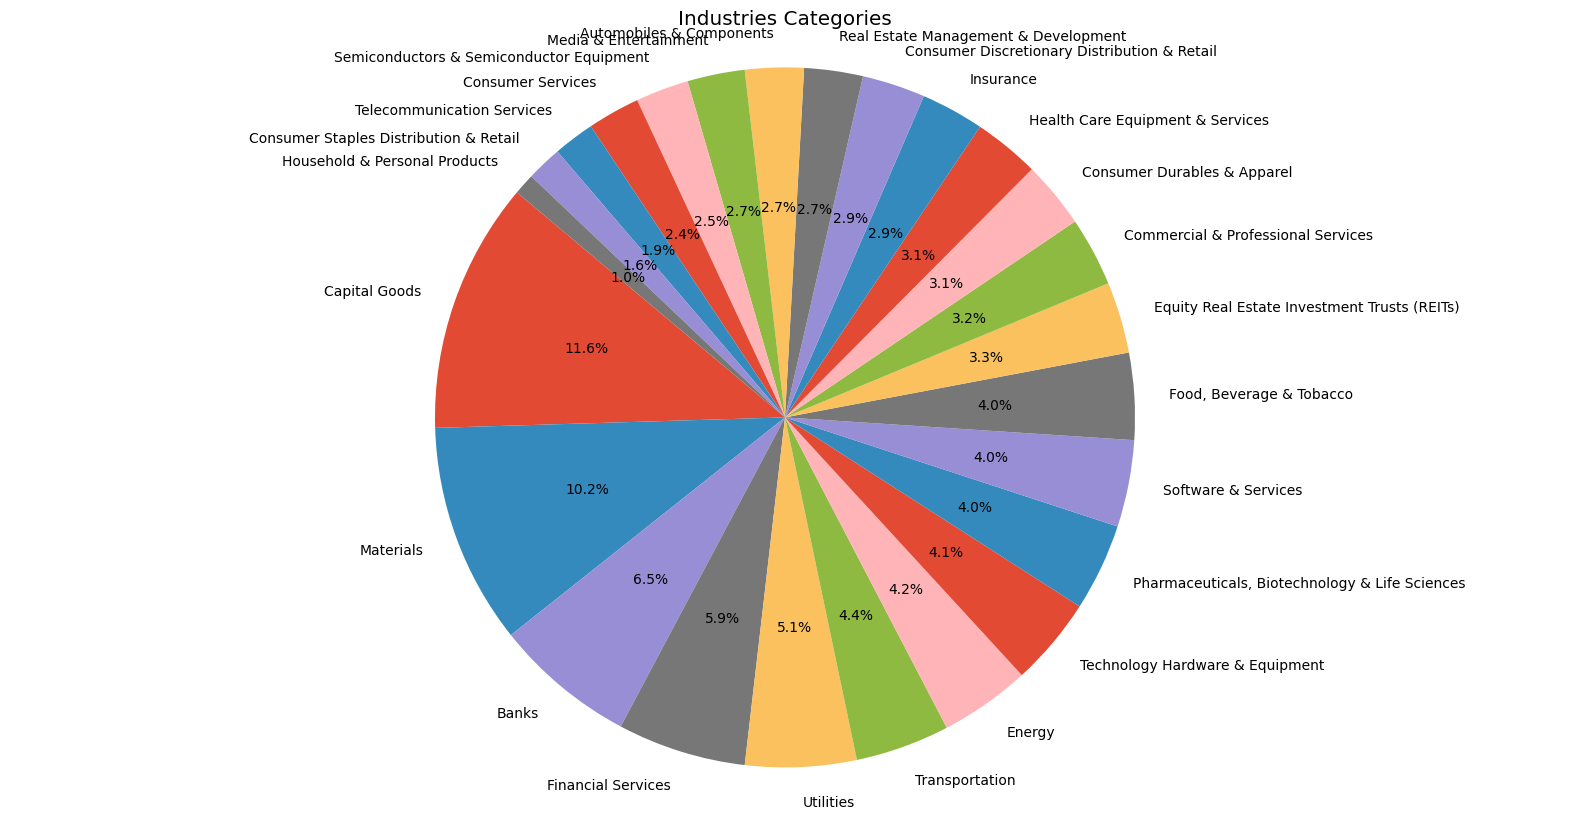

In [351]:
# Pie chart of value counts for IndustryGroup
industry_counts = df.value_counts("IndustryGroup")
plot_pie_chart(industry_counts, "Industries Categories")

# industry_counts

### Missing values

Checking for missing values in the data.

In [352]:
df.isna().sum()

IndustryGroup          0
TotalRevenue         572
DamageCost_Scope1    572
DamageCost_Scope2    572
dtype: int64

In [353]:
nan_companies = df.isna().any(axis=1)
df_nan = df[nan_companies]
df_nan

IndustryGroup  TotalRevenue  \
CompanyID                                                                 
COM0011                                             Banks           NaN   
COM0016                                             Banks           NaN   
COM0017                                             Banks           NaN   
COM0018                                             Banks           NaN   
COM0020                                             Banks           NaN   
...                                                   ...           ...   
COM3465                                         Materials           NaN   
COM3466                               Software & Services           NaN   
COM3467                                Financial Services           NaN   
COM3468    Pharmaceuticals, Biotechnology & Life Sciences           NaN   
COM3469                Commercial & Professional Services           NaN   

           DamageCost_Scope1  DamageCost_Scope2  
CompanyID                                        
COM0011                  NaN                NaN  
COM0016                  NaN                NaN  
COM0017                  NaN                NaN  
COM0018                  NaN                NaN  
COM0020                  NaN                NaN  
...                      ...                ...  
COM3465                  NaN                NaN  
COM3466                  NaN                NaN  
COM3467                  NaN                NaN  
COM3468                  NaN                NaN  
COM3469                  NaN                NaN  

[572 rows x 4 columns]

Missing values are present across the whole row, not randomly across columns

In [354]:
df_nan.describe()

TotalRevenue  DamageCost_Scope1  DamageCost_Scope2
count           0.0                0.0                0.0
mean            NaN                NaN                NaN
std             NaN                NaN                NaN
min             NaN                NaN                NaN
25%             NaN                NaN                NaN
50%             NaN                NaN                NaN
75%             NaN                NaN                NaN
max             NaN                NaN                NaN

They happen in all industries.

I won't do it, but it could be interesting to check if the industries with more missing values are the ones with higher emissions. Assuming that they are withholding information on purpose

In [355]:
df_nan.fillna(1).groupby("IndustryGroup").count()["TotalRevenue"].sort_values(
    ascending=False
)

IndustryGroup
Capital Goods                                     64
Financial Services                                52
Banks                                             41
Materials                                         40
Software & Services                               34
Insurance                                         26
Media & Entertainment                             25
Pharmaceuticals, Biotechnology & Life Sciences    23
Consumer Services                                 23
Health Care Equipment & Services                  22
Consumer Durables & Apparel                       20
Consumer Discretionary Distribution & Retail      20
Transportation                                    19
Energy                                            18
Commercial & Professional Services                18
Food, Beverage & Tobacco                          16
Equity Real Estate Investment Trusts (REITs)      16
Real Estate Management & Development              14
Automobiles & Components        

```text
Given the context of the data, it doesn't seem that the missing values originate from mistakes in data collection, more likely the companies simply do not report their emissions.

So for now I will remove them to keep the analysis clean.

When assigning a score, I will probably do some imputation. Zero does not make sense as it would imply that the company has no emissions, infinite would penalize heavily.
I will probably estimate something in relation to the industry, maybe combining the average for both Scope 1 and Scope 2 emissions.
```

In [356]:
# Dropping for now
df = df[np.logical_not(nan_companies)]

# Checking all industries have at least one company left
df.value_counts("IndustryGroup")

IndustryGroup
Capital Goods                                     338
Materials                                         314
Banks                                             186
Utilities                                         167
Financial Services                                154
Transportation                                    132
Technology Hardware & Equipment                   129
Energy                                            127
Food, Beverage & Tobacco                          123
Pharmaceuticals, Biotechnology & Life Sciences    117
Software & Services                               105
Equity Real Estate Investment Trusts (REITs)       98
Commercial & Professional Services                 93
Consumer Durables & Apparel                        87
Health Care Equipment & Services                   84
Consumer Discretionary Distribution & Retail       81
Real Estate Management & Development               80
Automobiles & Components                           80
Semiconductors

### Visualizing features

In [357]:
def plot_violins(df: "pd.DataFrame", columns: list, title: str = "Violin Plot") -> None:
    """
    Plot a violin plot for the given column in the DataFrame.
    """
    fig, axes = plt.subplots(len(columns), 1, figsize=(20, 12))
    fig.suptitle(title, fontsize=16)
    for i, feature in enumerate(columns):
        sns.violinplot(df, x=feature, ax=axes[i])
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Density")

    plt.show()

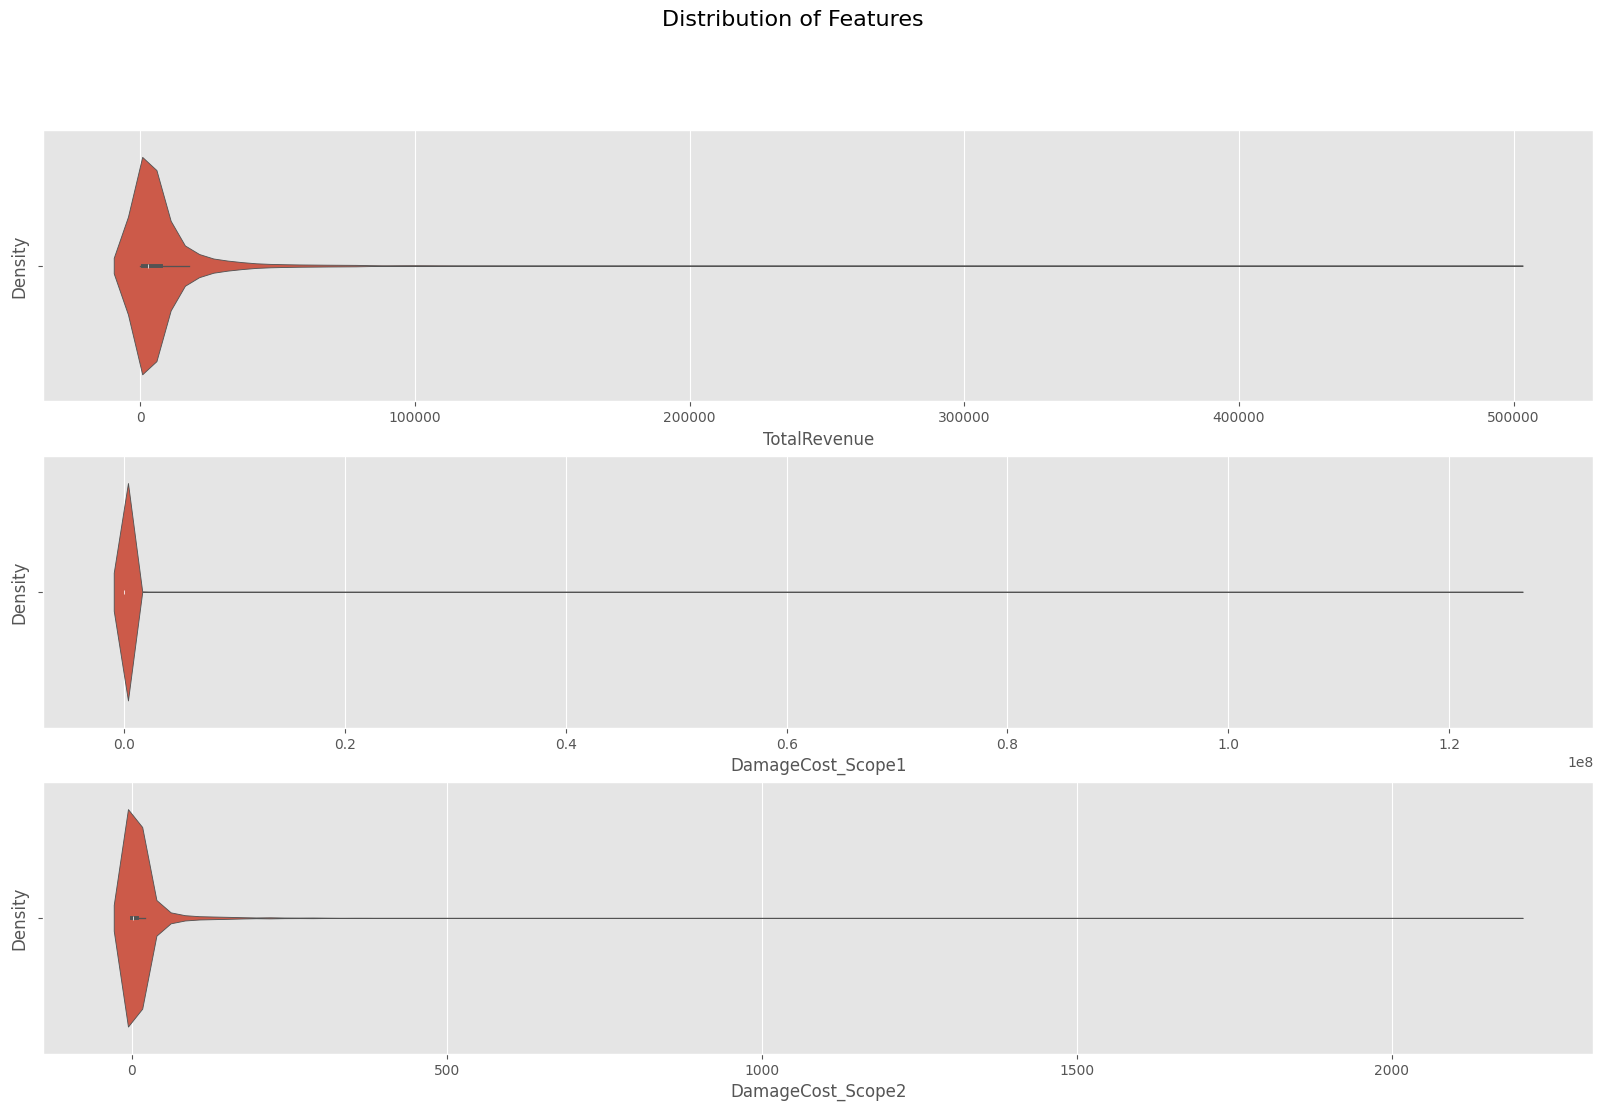

In [358]:
features = ["TotalRevenue", "DamageCost_Scope1", "DamageCost_Scope2"]
plot_violins(df, features, "Distribution of Features")

```text
Highly skewed
```

### Analyzing outliers

I would ask why are they outliers. Again, given the context they probably are not mistakes, just companies with high revenue or emissions

In [359]:
# Defining as outlier those above the q75
q75_revenue = np.quantile(df["TotalRevenue"], q=0.75)
q75_direct = np.quantile(df["DamageCost_Scope1"], q=0.75)
q75_indirect = np.quantile(df["DamageCost_Scope2"], q=0.75)

# Get a list of companies that are outliers
df_outliers = pd.DataFrame(df["IndustryGroup"])
df_outliers["IsOutlier"] = (
    (df["TotalRevenue"] > q75_revenue)
    | (df["DamageCost_Scope1"] > q75_direct)
    | (df["DamageCost_Scope2"] > q75_indirect)
)

In [360]:
def plot_countplot(
    df: "pd.DataFrame", column: str, order, title: str = "Count Plot"
) -> None:
    """
    Plot a count plot for the given column in the DataFrame.
    """
    plt.figure(figsize=(20, 10))
    sns.countplot(data=df, y=column, order=order, palette="viridis", legend=False)
    plt.title(title)
    plt.show()

C:\Users\n118768\AppData\Local\Temp\ipykernel_3676\24318750.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=order, palette="viridis", legend=False)


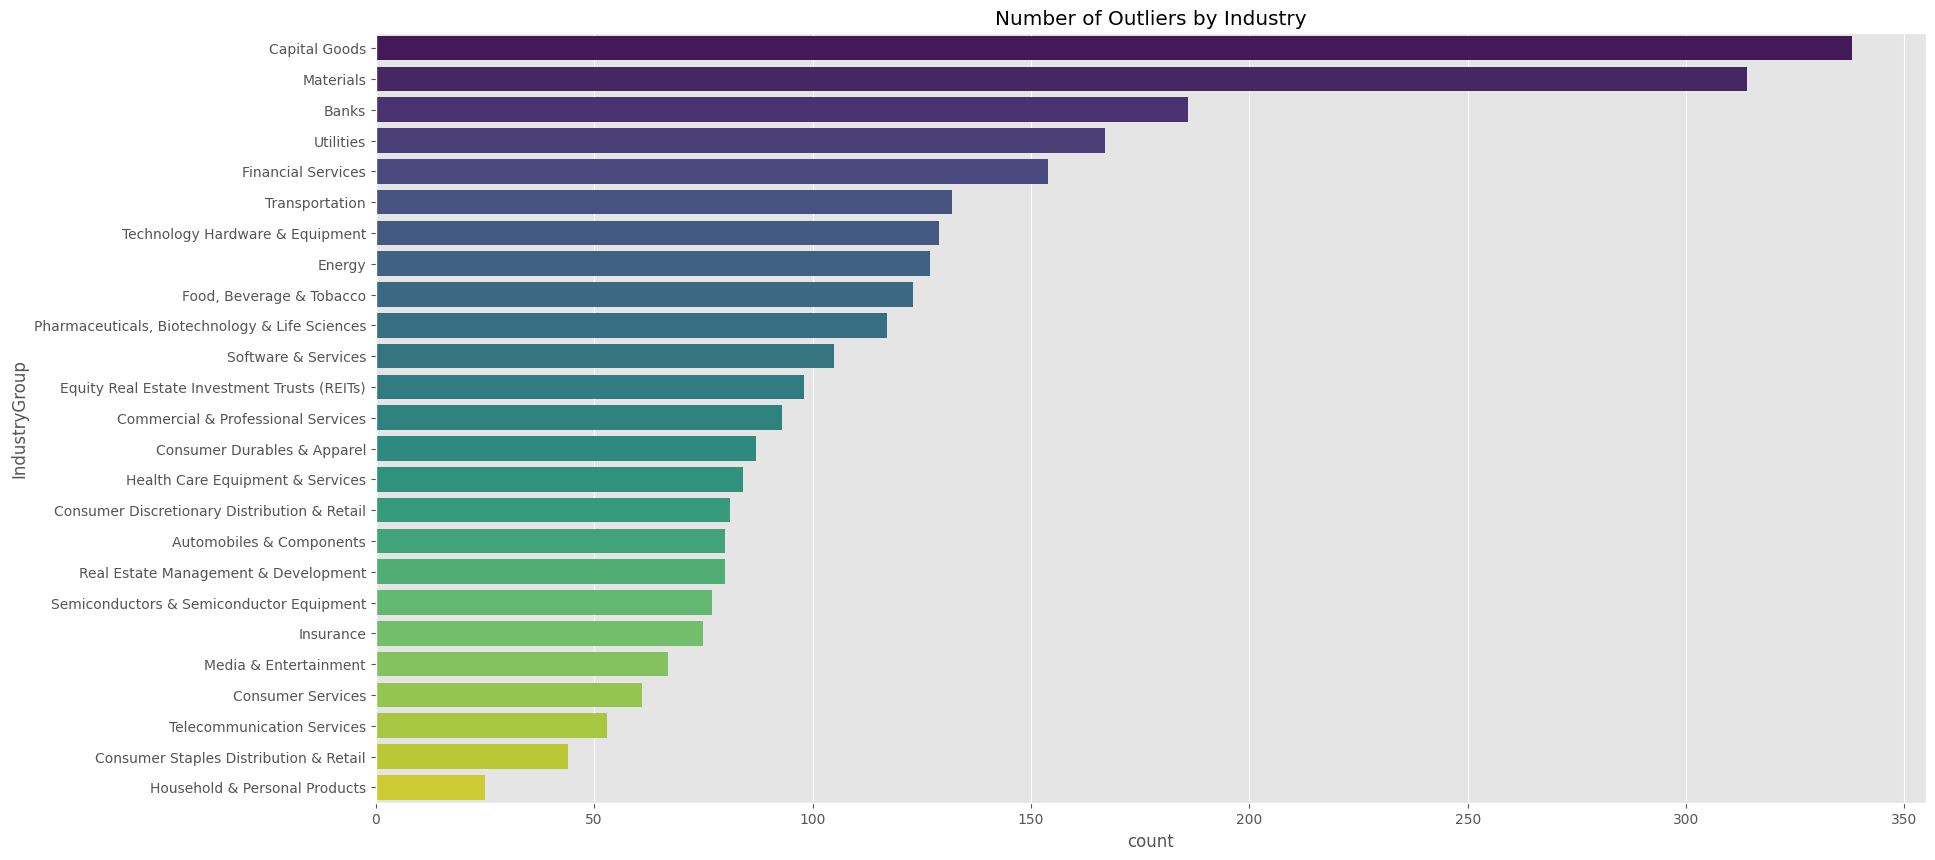

In [361]:
plot_countplot(
    df_outliers,
    "IndustryGroup",
    order=df_outliers["IndustryGroup"].value_counts().index,
    title="Number of Outliers by Industry",
)

Would be interesting to check if the industries with more outliers are the ones with higher variance in emissions

In [362]:
def plot_boxplots(df: "pd.DataFrame", features: list, title: str = "Boxplots") -> None:
    """
    Plot boxplots for the given features in the DataFrame.
    """
    fig, axes = plt.subplots(len(features), 1, figsize=(20, 15))
    fig.suptitle(title, fontsize=16)
    palette = sns.color_palette("Set2")
    for i, (feature, q75, name) in enumerate(features):
        sns.boxplot(data=df[df[feature] < q75], x=feature, ax=axes[i], color=palette[i])
        axes[i].set_ylabel("Value")
        # axes[i].grid(True, linestyle="--", alpha=0.6)

    plt.show()

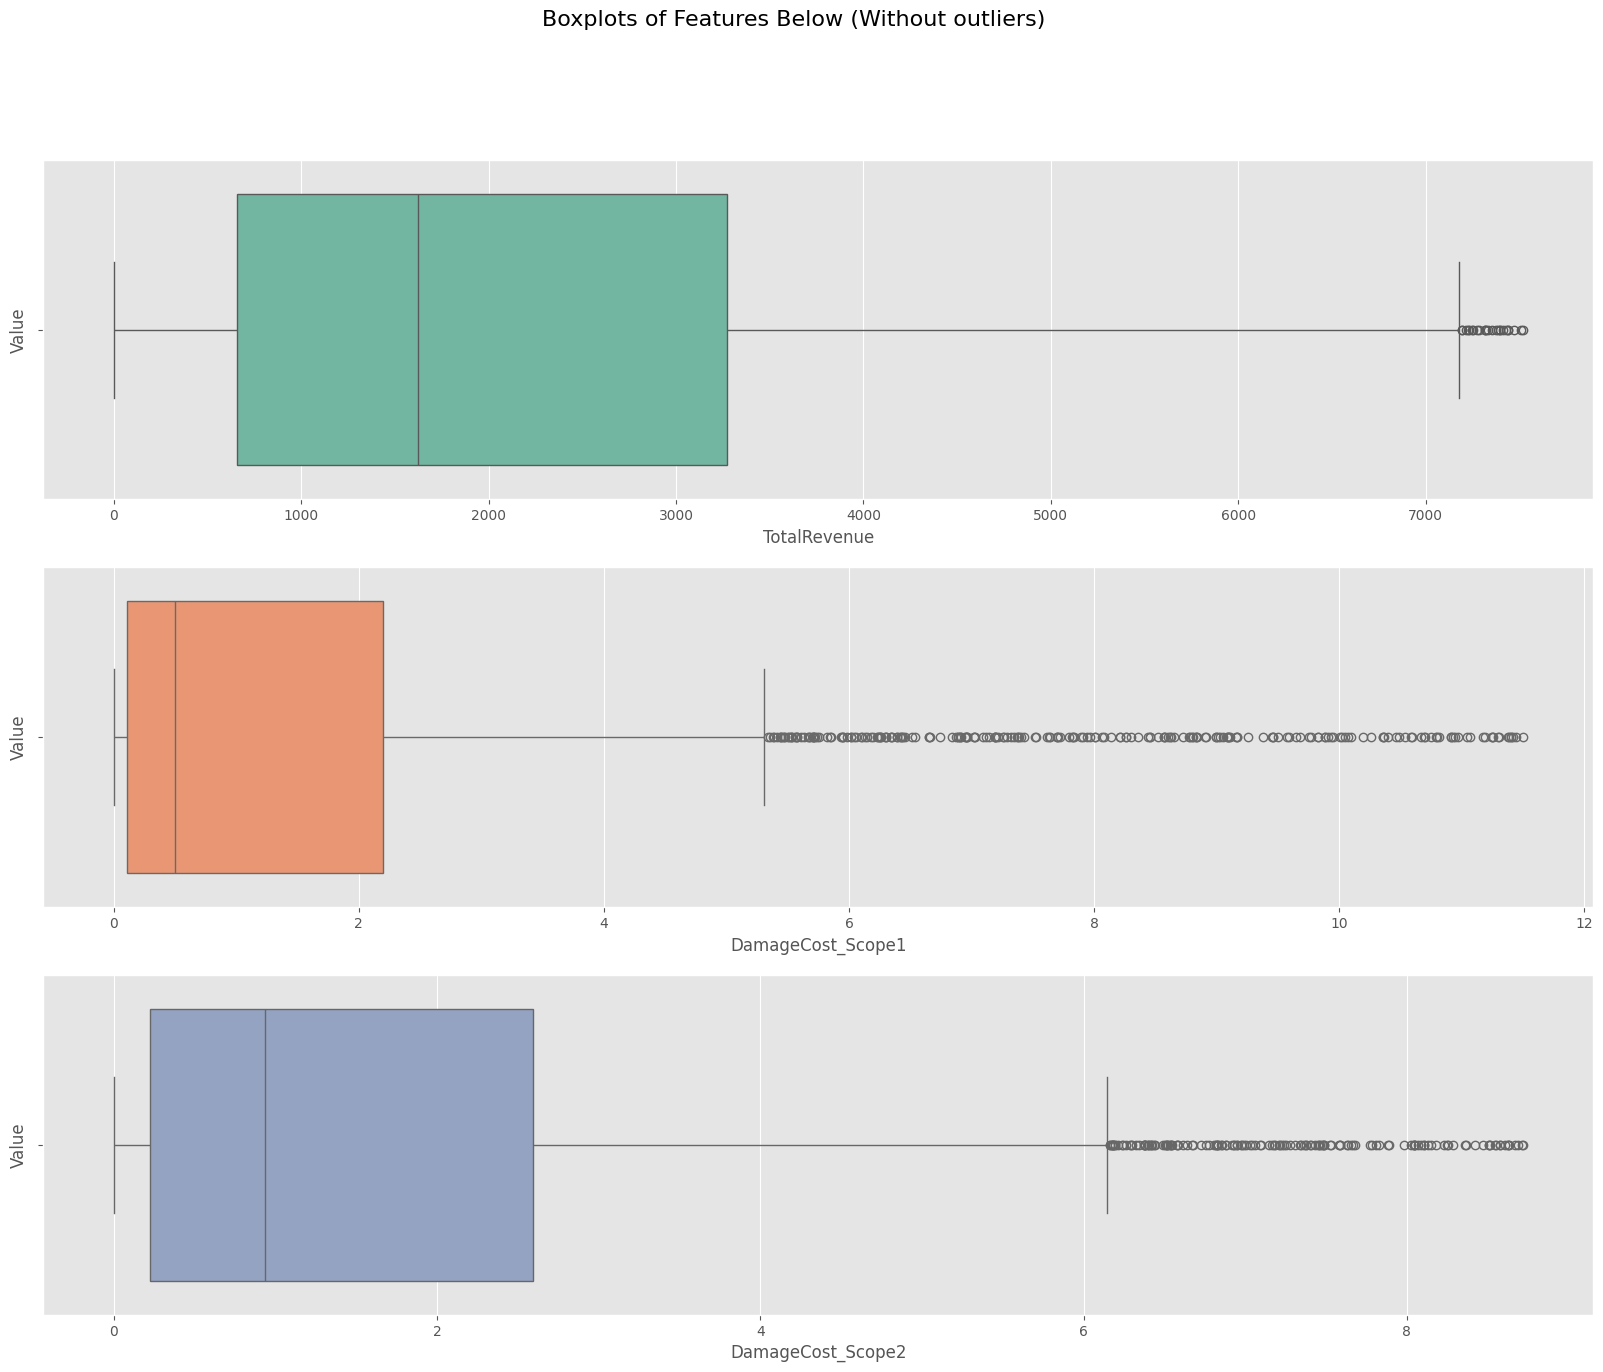

In [363]:
plot_boxplots(
    df,
    features=[
        ("TotalRevenue", q75_revenue, "Total Revenue"),
        ("DamageCost_Scope1", q75_direct, "Scope 1 Damage Cost"),
        ("DamageCost_Scope2", q75_indirect, "Scope 2 Damage Cost"),
    ],
    title="Boxplots of Features Below (Without outliers)",
)

C:\Users\n118768\AppData\Local\Temp\ipykernel_3676\24318750.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=order, palette="viridis", legend=False)


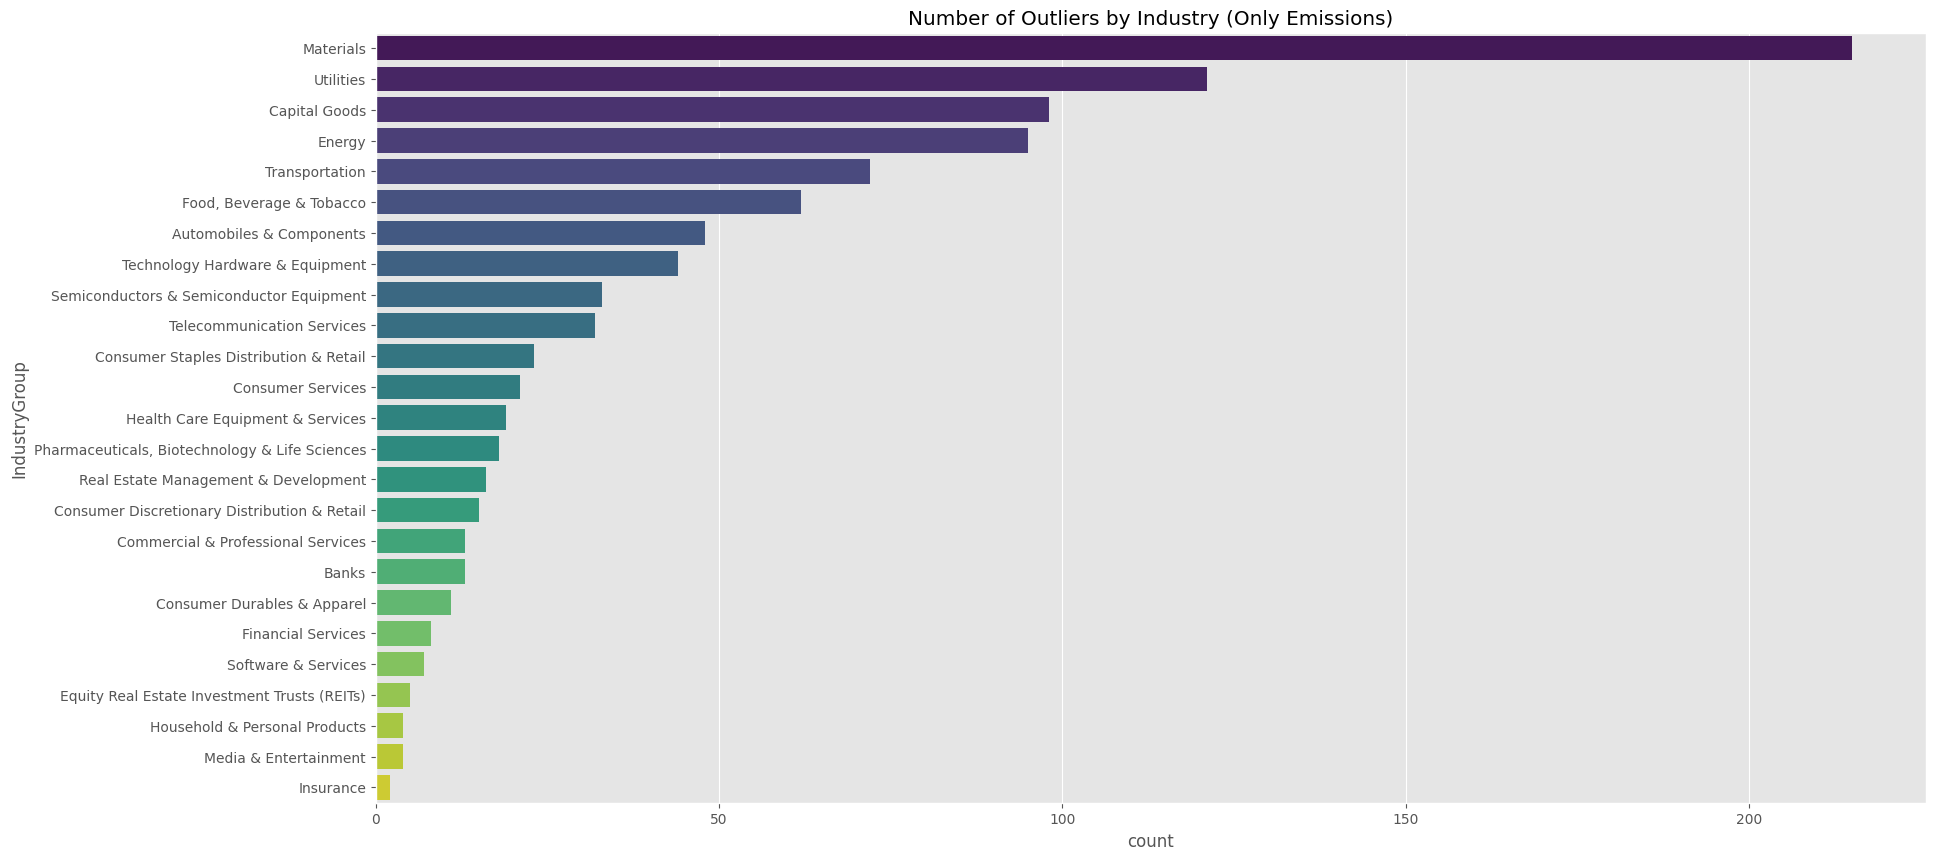

In [364]:
# Now without revenue
df_outliers["IsOutlier"] = (df["DamageCost_Scope1"] > q75_direct) | (
    df["DamageCost_Scope2"] > q75_indirect
)
df_outliers = df_outliers[df_outliers["IsOutlier"]]

plot_countplot(
    df_outliers,
    "IndustryGroup",
    order=df_outliers["IndustryGroup"].value_counts().index,
    title="Number of Outliers by Industry (Only Emissions)",
)

## Exercise 1:

> As Data Scientist you’re tasked to analyze environmental data coming from an internal database, covering Scope 1 and Scope 2 Damage Costs and Revenues (please note not all companies have data available). 
The target of this first exercise is to calculate the Impact Ratios of companies and to create a narrative around industries with higher and lower Impact Ratios. The Impact Ratio of a company is defined as the Damage Cost divided by the Total Revenues. These values are provided in the Table 1 of the Excel provided, for Scope 1 and Scope 2. Industries are separately provided in Table 2. 

**Calculating Impact Ratios**

In [365]:
df["ImpactRatio_Scope1"] = df["DamageCost_Scope1"] / df["TotalRevenue"]
df["ImpactRatio_Scope2"] = df["DamageCost_Scope2"] / df["TotalRevenue"]

df.describe()

TotalRevenue  DamageCost_Scope1  DamageCost_Scope2  \
count    2897.000000       2.897000e+03        2897.000000   
mean     8913.320889       4.349717e+04          15.767660   
std     23854.406534       2.335915e+06          69.893906   
min         0.121100       0.000000e+00           0.000000   
25%       912.898386       1.801503e-01           0.381507   
50%      2612.386613       1.390032e+00           1.823798   
75%      7626.000000       1.152834e+01           8.721362   
max    493700.155599       1.257279e+08        2179.249475   

       ImpactRatio_Scope1  ImpactRatio_Scope2  
count         2897.000000         2897.000000  
mean             0.833821            0.002421  
std             44.194297            0.012471  
min              0.000000            0.000000  
25%              0.000109            0.000247  
50%              0.000540            0.000682  
75%              0.002815            0.002124  
max           2378.714582            0.627570

In [366]:
# Apply log scale to the axes
df["ImpactRatio_Scope1"] = df["ImpactRatio_Scope1"].replace(0, np.nan)
df["ImpactRatio_Scope2"] = df["ImpactRatio_Scope2"].replace(0, np.nan)

df["Log_ImpactRatio_Scope1"] = np.log10(df["ImpactRatio_Scope1"])
df["Log_ImpactRatio_Scope2"] = np.log10(df["ImpactRatio_Scope2"])

In [367]:
# Sort columns by ratio
df_industry = df.groupby(
    "IndustryGroup"
).median()  # Median less sensitive to outliers than mean

order_scope1 = df_industry.sort_values("ImpactRatio_Scope1", ascending=False).index
order_scope2 = df_industry.sort_values("ImpactRatio_Scope2", ascending=False).index

order_colors_scope1 = sns.color_palette("RdYlGn_r", n_colors=len(order_scope1))
order_colors_scope2 = sns.color_palette("coolwarm", n_colors=len(order_scope1))

# We reverse the order to have the highest impact ratios at the top
order_colors_scope1.reverse()
order_colors_scope2.reverse()

**Visualizing Impact Ratios**

Hypothesis to test: It’s expected that companies will have a higher or lower impact ratio depending on their business

In [368]:
def plot_boxplot(
    df: "pd.DataFrame", column: str, hue: str, order, palette, title: str = "Boxplot"
) -> None:
    """
    Plot a boxplot for the given column in the DataFrame.
    """
    plt.figure(figsize=(20, 10))
    sns.boxplot(
        data=df,
        x=column,
        y=hue,
        hue=hue,
        order=order,
        hue_order=order,
        palette=palette,
        # showfliers=False
    )
    plt.title(title)
    plt.show()

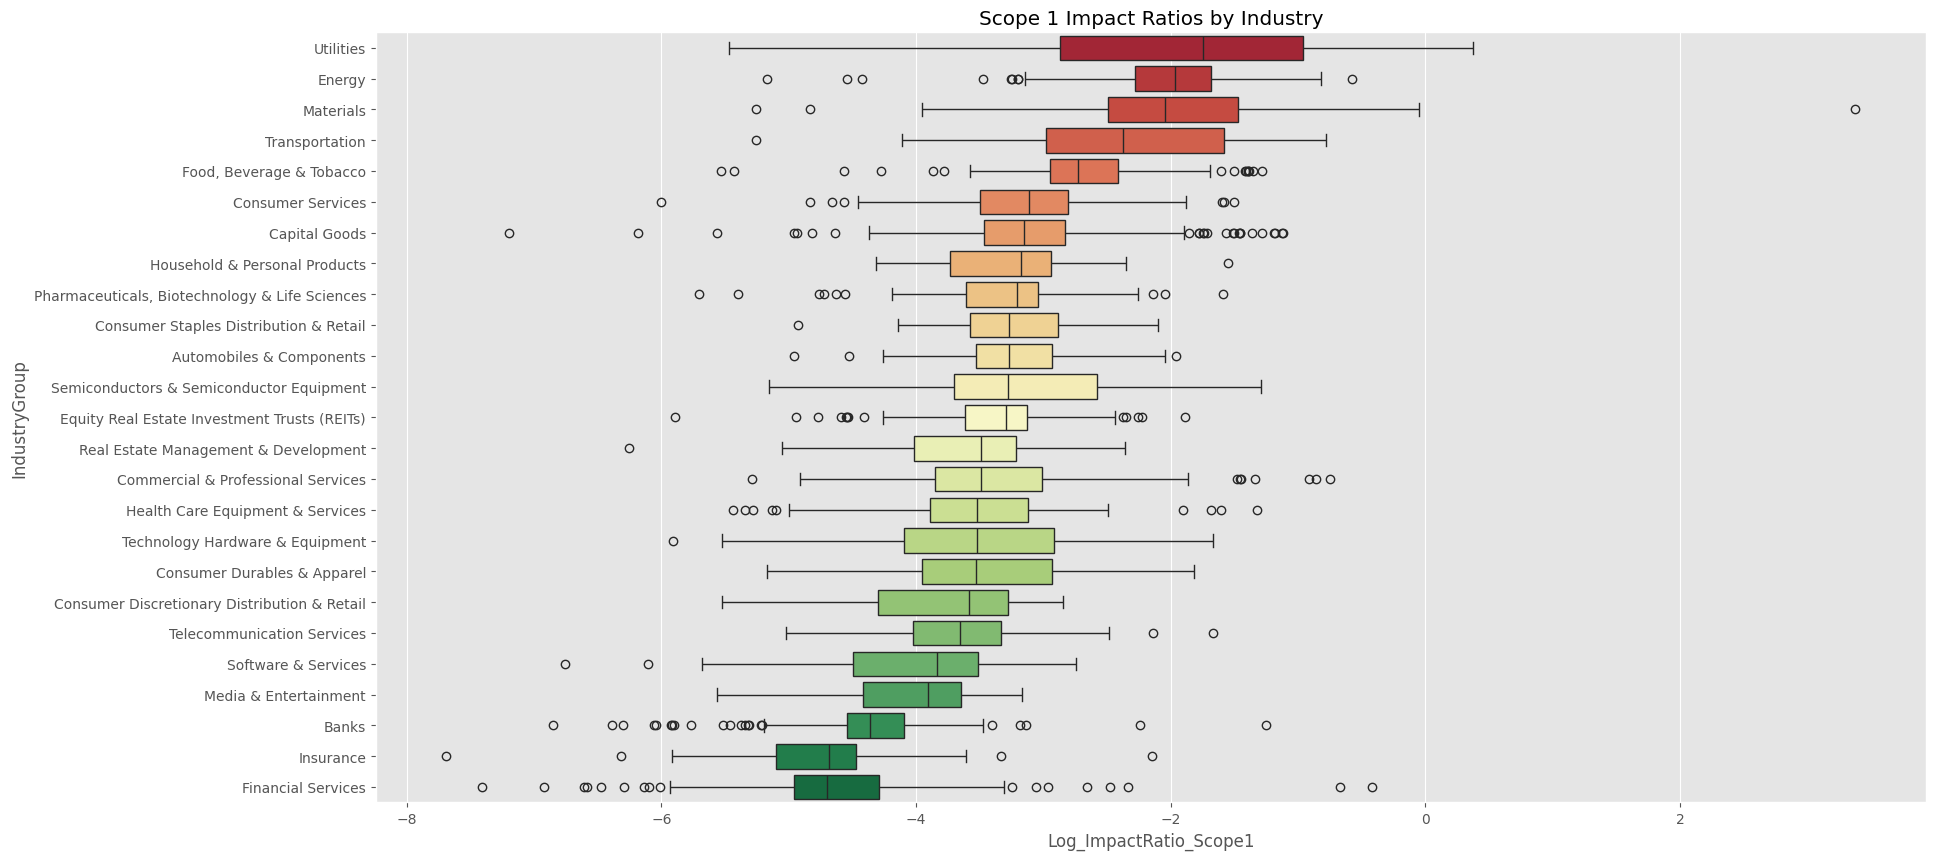

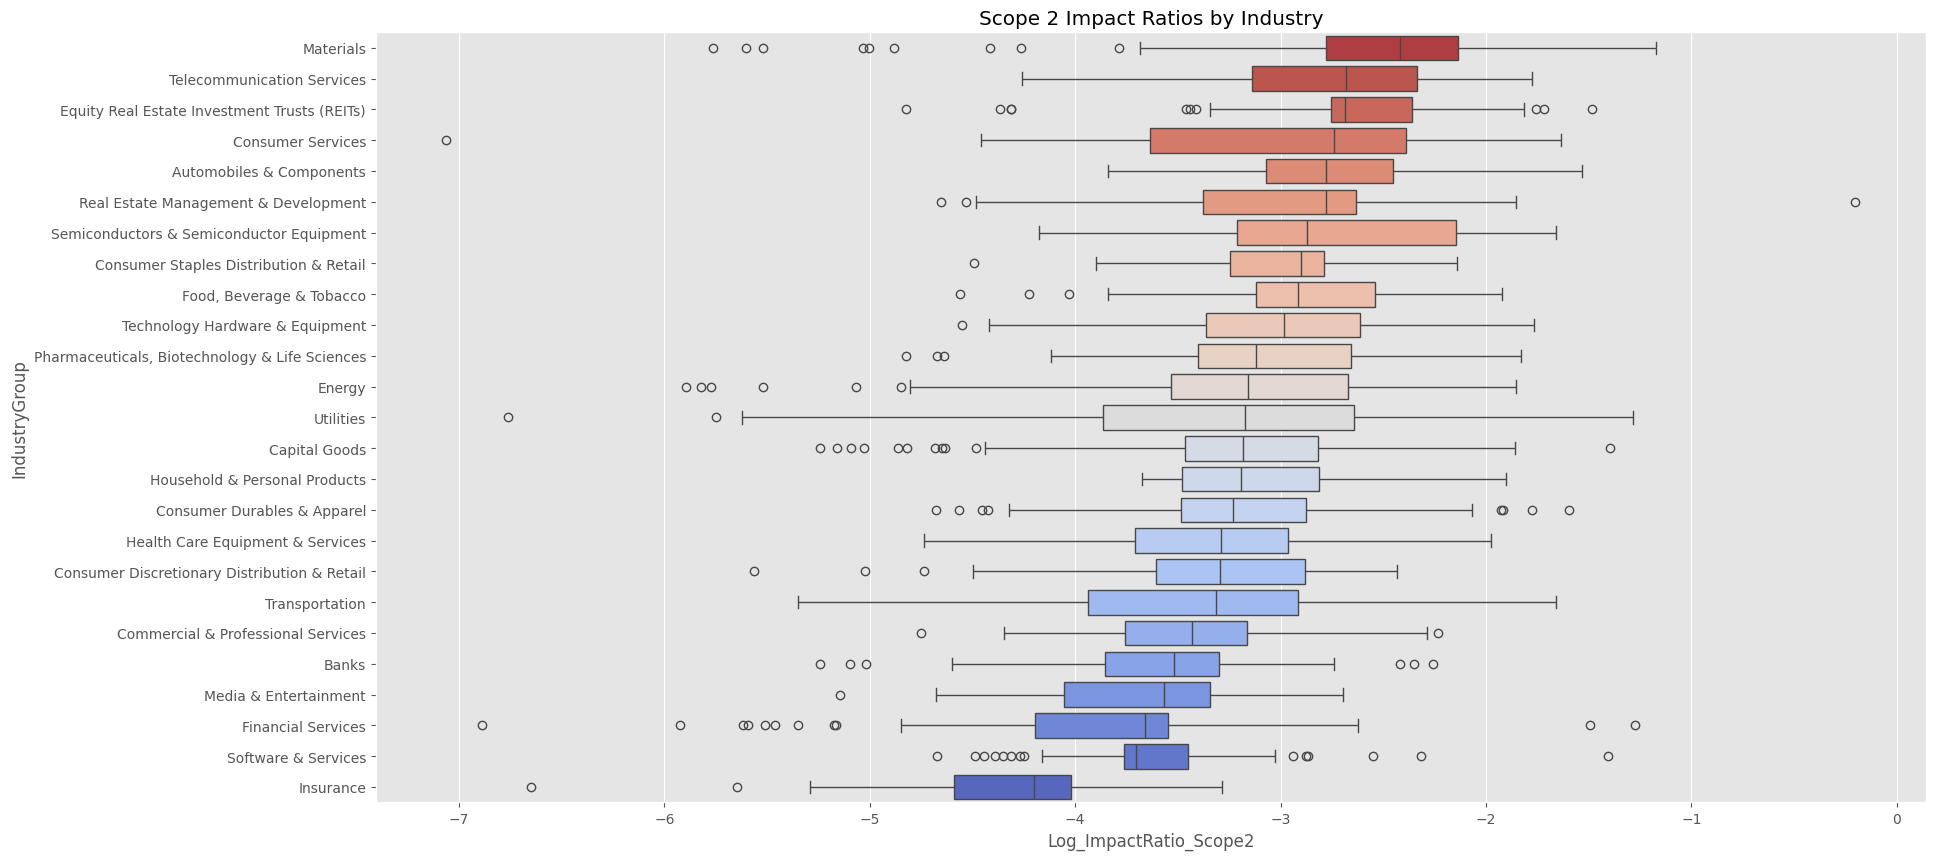

In [369]:
plot_boxplot(
    df,
    column="Log_ImpactRatio_Scope1",
    hue="IndustryGroup",
    order=order_scope1,
    palette=order_colors_scope1,
    title="Scope 1 Impact Ratios by Industry",
)

plot_boxplot(
    df,
    column="Log_ImpactRatio_Scope2",
    hue="IndustryGroup",
    order=order_scope2,
    palette=order_colors_scope2,
    title="Scope 2 Impact Ratios by Industry",
)

Clearly there is a difference in impact ratios between industries. For Scope 1 as well as Scope 2.

We could conduct a test (e.g. t-test) to check if the difference is statistically significant, but visually it is already clear that there is a difference.

In [370]:
def plot_industrygroup_hist_split(df, order, column, log_scale=True, figsize=(20, 15)):
    """Plot histogram of a column split by half of IndustryGroups in two subplots."""
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
    industry_groups = list(order)
    mid = len(industry_groups) // 2
    groups1 = industry_groups[:mid]
    groups2 = industry_groups[mid:]

    # Determine common x-axis limits for both subplots
    xmin = df[column].min()
    xmax = df[column].max()

    # First half of IndustryGroups
    sns.histplot(
        df[df["IndustryGroup"].isin(groups1)],
        x=column,
        log_scale=log_scale,
        hue="IndustryGroup",
        hue_order=groups1,
        ax=axes[0],
        # multiple="stack",
    )
    axes[0].set_title(f"IndustryGroup (First Half) - {column}")
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_xlabel(column)

    # Second half of IndustryGroups
    sns.histplot(
        df[df["IndustryGroup"].isin(groups2)],
        x=column,
        log_scale=log_scale,
        hue="IndustryGroup",
        hue_order=groups2,
        ax=axes[1],
        # multiple="stack",
    )
    axes[1].set_title(f"IndustryGroup (Second Half) - {column}")
    axes[1].set_xlim(xmin, xmax)
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

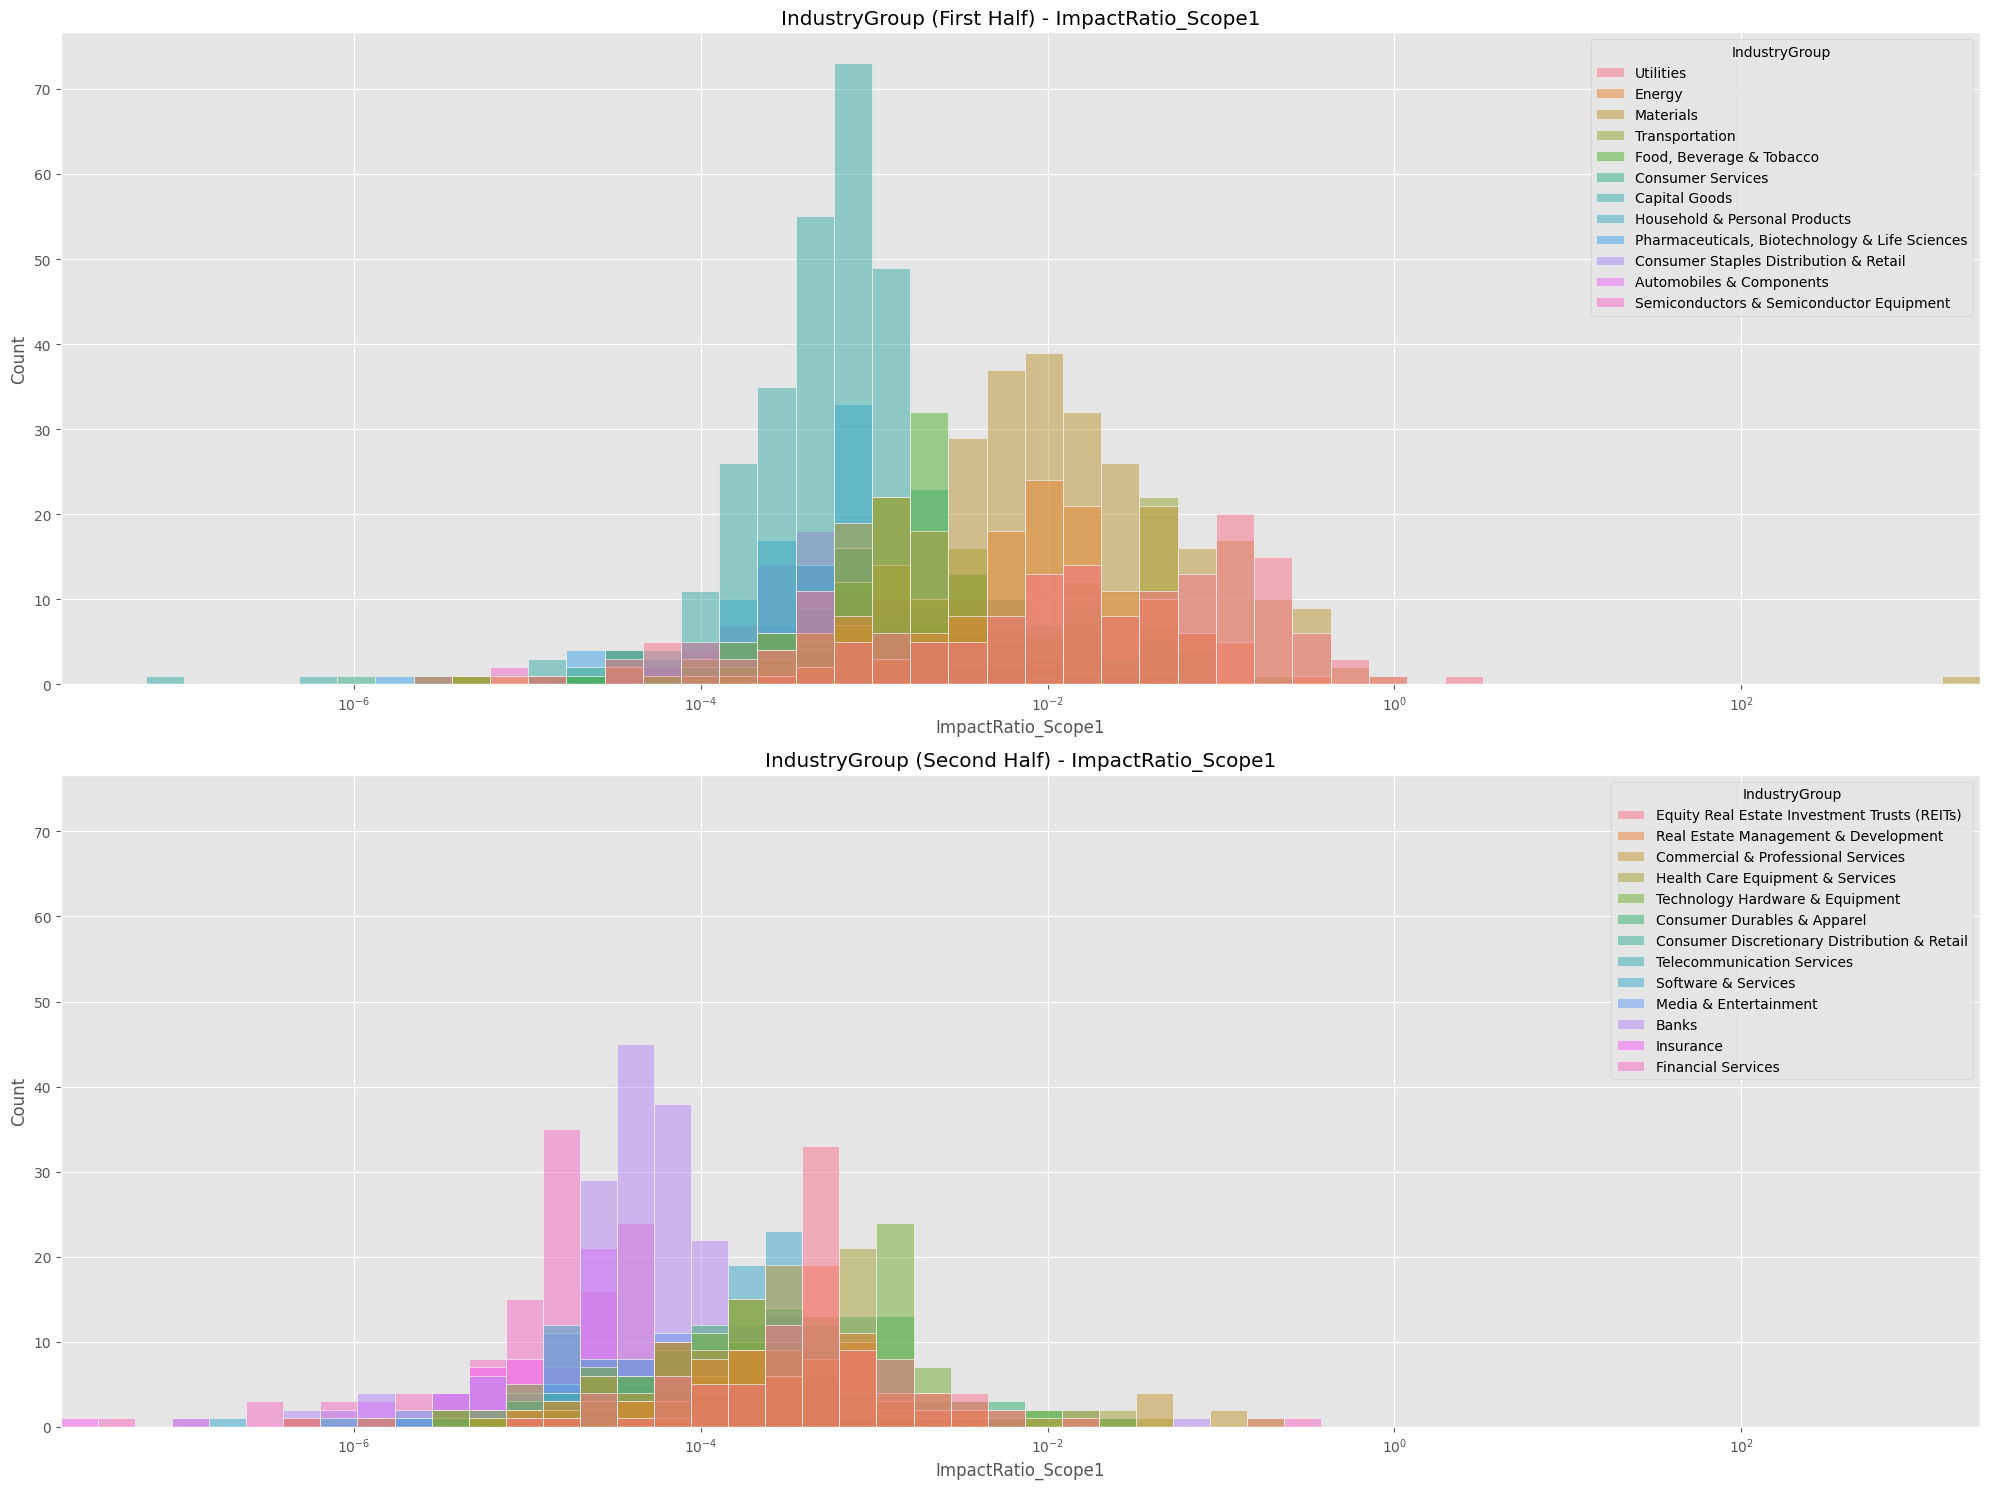

In [371]:
# Careful: In log scale
plot_industrygroup_hist_split(df, order_scope1, "ImpactRatio_Scope1")

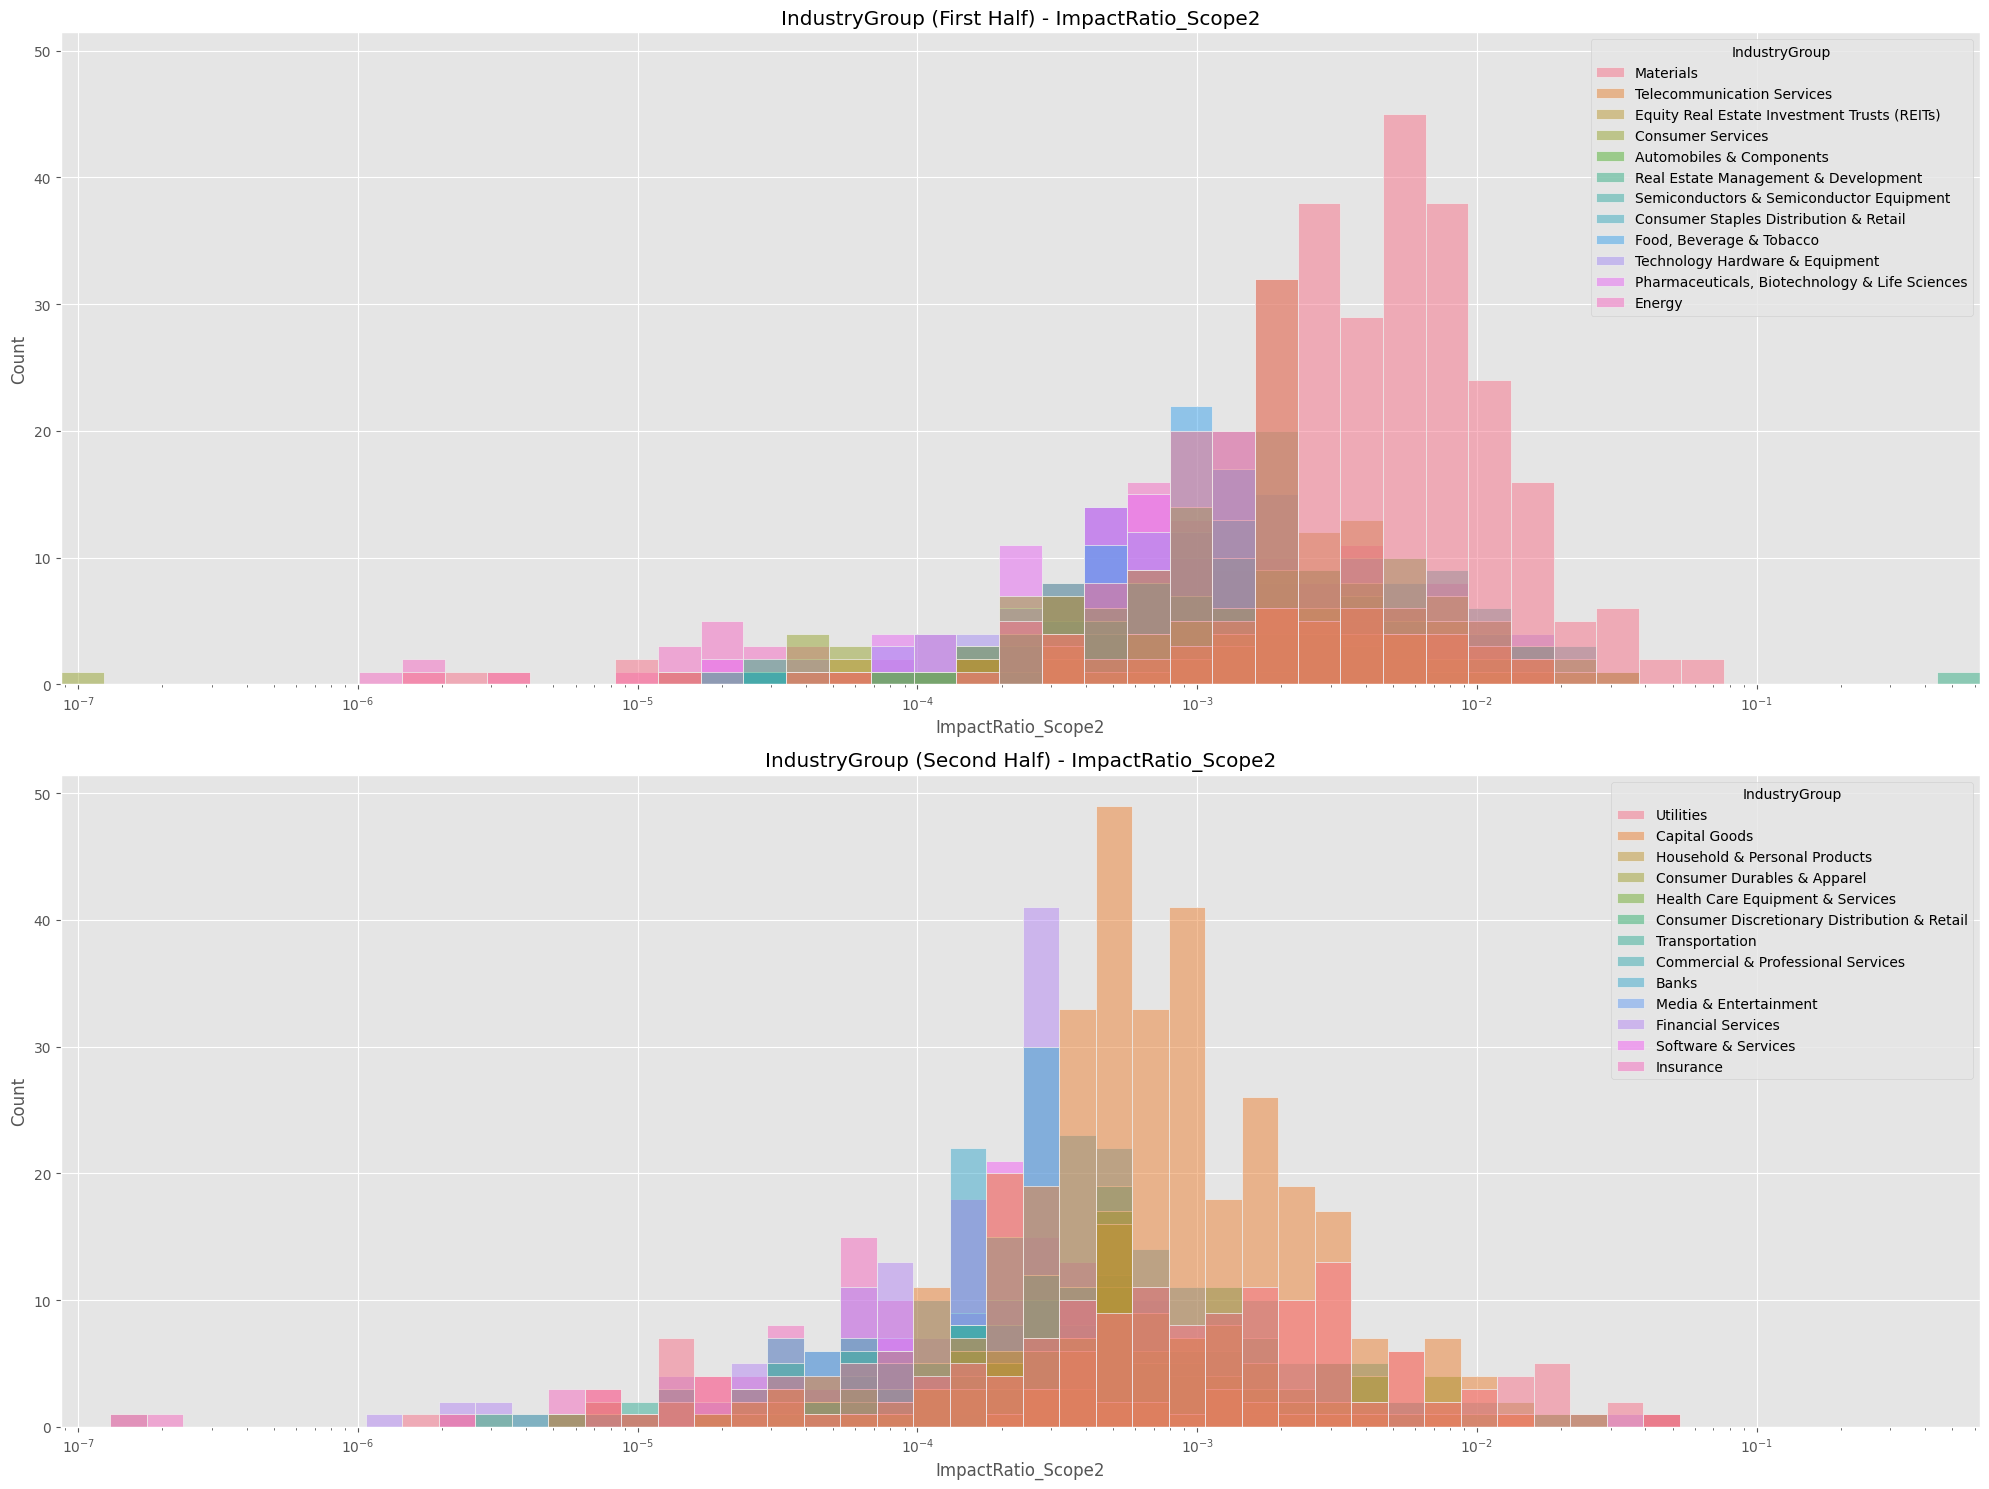

In [372]:
plot_industrygroup_hist_split(df, order_scope2, "ImpactRatio_Scope2")

There are in log-scale, so they are clearly not normally distributed

In [373]:
def plot_scatterplot(
    df: "pd.DataFrame",
    x: str,
    y: str,
    hue: str,
    title: str = "Scatter Plot",
    palette=None,
) -> None:
    """
    Plot a scatter plot for the given columns in the DataFrame.
    """
    plt.figure(figsize=(20, 10))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        alpha=0.7,
        palette=palette,
    )
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(title=hue)
    plt.show()

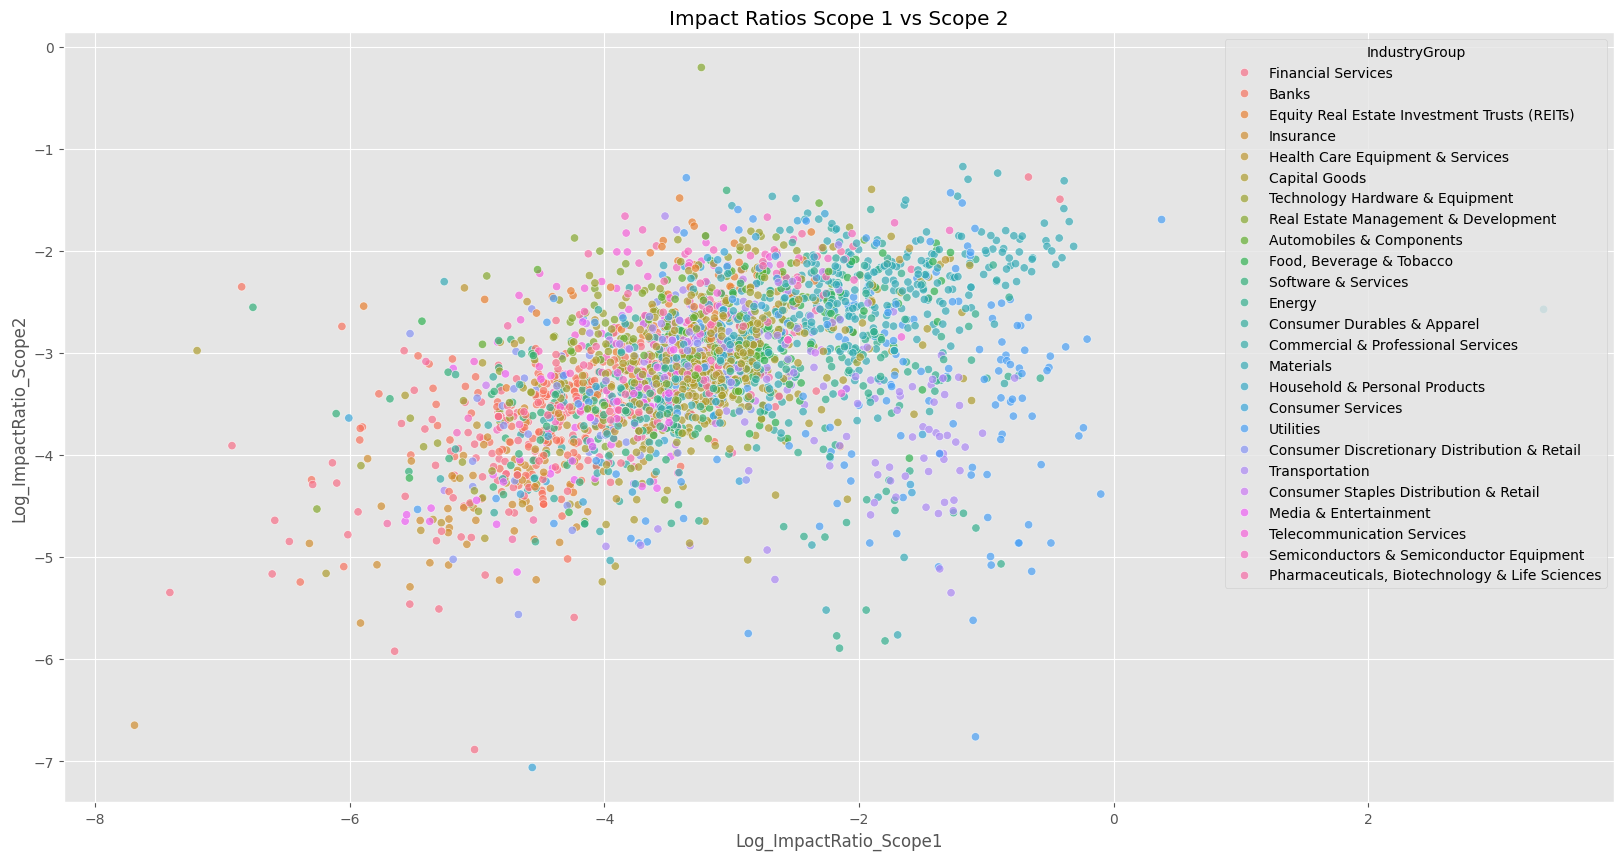

In [374]:
plot_scatterplot(
    df,
    x="Log_ImpactRatio_Scope1",
    y="Log_ImpactRatio_Scope2",
    hue="IndustryGroup",
    title="Impact Ratios Scope 1 vs Scope 2",
)

**Analyzing Impact Ratios by industry**

In [375]:
# Compare rankings in Scope 1 and Scope 2
df_ranking = pd.DataFrame(
    index=order_scope1, columns=["Scope1_Rank", "Scope2_Rank"], data=np.nan
)

df_ranking["Scope1_Rank"] = df_industry["ImpactRatio_Scope1"].rank(ascending=True)
df_ranking["Scope2_Rank"] = df_industry["ImpactRatio_Scope2"].rank(ascending=True)

df_ranking

Scope1_Rank  Scope2_Rank
IndustryGroup                                                           
Utilities                                              25.0         13.0
Energy                                                 24.0         14.0
Materials                                              23.0         25.0
Transportation                                         22.0          7.0
Food, Beverage & Tobacco                               21.0         17.0
Consumer Services                                      20.0         22.0
Capital Goods                                          19.0         12.0
Household & Personal Products                          18.0         11.0
Pharmaceuticals, Biotechnology & Life Sciences         17.0         15.0
Consumer Staples Distribution & Retail                 16.0         18.0
Automobiles & Components                               15.0         21.0
Semiconductors & Semiconductor Equipment               14.0         19.0
Equity Real Estate Investment Trusts (REITs)           13.0         23.0
Real Estate Management & Development                   12.0         20.0
Commercial & Professional Services                     11.0          6.0
Health Care Equipment & Services                       10.0          9.0
Technology Hardware & Equipment                         9.0         16.0
Consumer Durables & Apparel                             8.0         10.0
Consumer Discretionary Distribution & Retail            7.0          8.0
Telecommunication Services                              6.0         24.0
Software & Services                                     5.0          2.0
Media & Entertainment                                   4.0          4.0
Banks                                                   3.0          5.0
Insurance                                               2.0          1.0
Financial Services                                      1.0          3.0

In [376]:
# Reversing the orders because we move past ratios
order_colors_scope1 = order_colors_scope1[::-1]
order_colors_scope2 = order_colors_scope2[::-1]

In [377]:
def plot_heatmap(
    df: "pd.DataFrame", order, title: str = "Heatmap", vmax: int = None
) -> None:
    """
    Plot a heatmap for the given DataFrame.
    """
    plt.figure(figsize=(20, 10))
    vmax = vmax if vmax is not None else len(order)
    sns.heatmap(
        df,
        annot=True,
        cmap=order,
        cbar_kws={"label": "Rank"},
        linewidths=0.5,
        linecolor="black",
        vmin=1,
        vmax=vmax,  # Set vmin and vmax to the number of ranks
    )
    plt.title(title)
    plt.show()

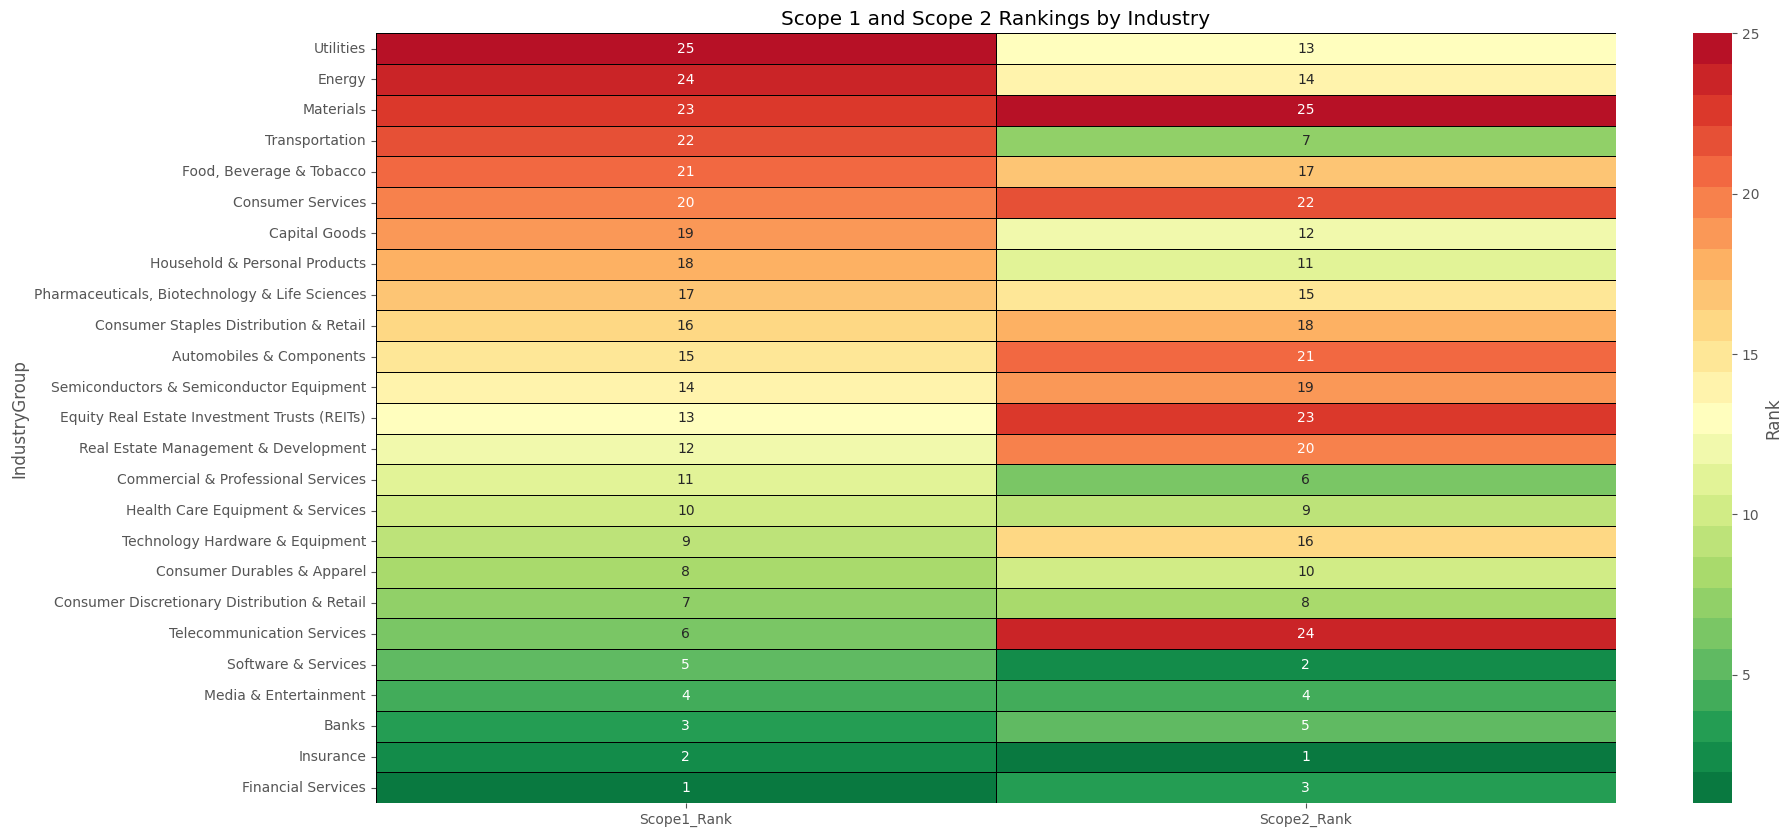

In [378]:
plot_heatmap(
    df_ranking[["Scope1_Rank", "Scope2_Rank"]],
    order=order_colors_scope1,
    title="Scope 1 and Scope 2 Rankings by Industry",
)

To compare them better, I group them in groups of 5

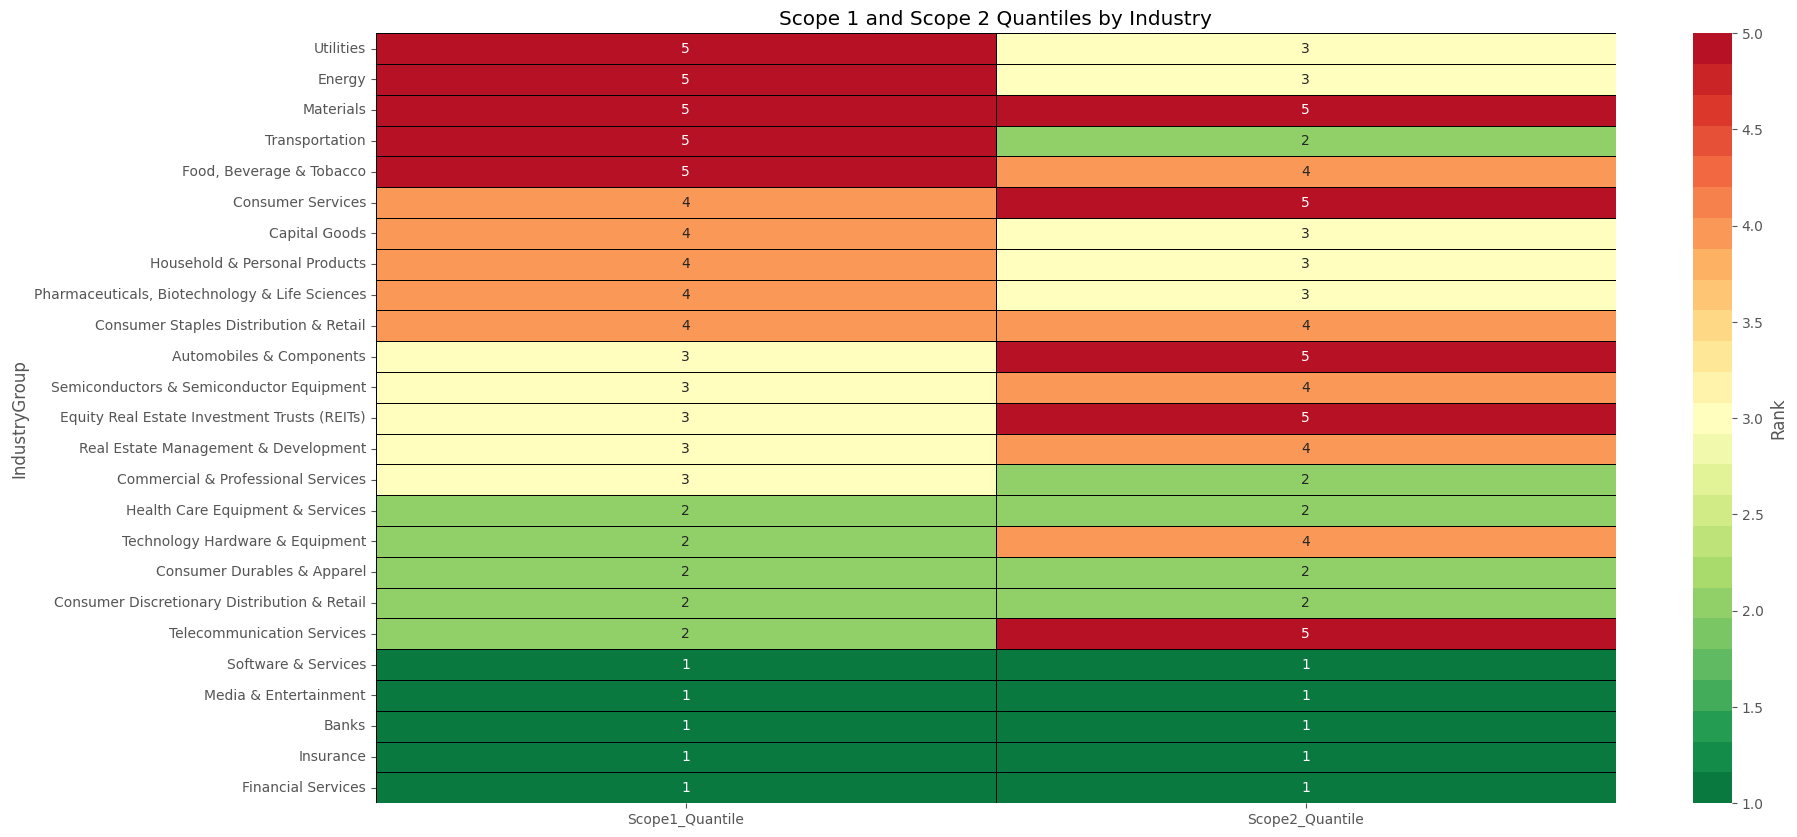

In [379]:
# Group ranking in quantiles and plot them again
df_ranking["Scope1_Quantile"] = (
    pd.qcut(df_ranking["Scope1_Rank"], q=5, labels=False) + 1
)
df_ranking["Scope2_Quantile"] = (
    pd.qcut(df_ranking["Scope2_Rank"], q=5, labels=False) + 1
)


plot_heatmap(
    df_ranking[["Scope1_Quantile", "Scope2_Quantile"]],
    order=order_colors_scope1,
    title="Scope 1 and Scope 2 Quantiles by Industry",
    vmax=5,
)

Conclusions:
- Clearly Media&Entertainment, Software&Services, Banks, Insurance and Financial Services have the lowest Impact Ratios
- There are those with high direct emissions and low indirect emissions, such as Transportation, Utilities and Energy
- And those with high indirect emissions and low direct emissions, such as Telecommunication, Technology, REITs

## Exercise 2:
	
> Leveraging the work done in the first exercise, your task now is to deepen the analysis on Impact Ratios, by defining a scoring logic for companies. Each company shall receive a score between 0 and 100 depending on their Scope 1 and Scope 2 Impact Ratios (separately). You’re free to assign the score using the method you consider more relevant, but beware of outliers. 

> Hint: Assign a 0-100 score is easier when the underlying data is normally distributed (or close to normal at least), because in this case simple rank or linear functions can work well. Look at the distribution of Impact Ratios overall, you might want to apply transformations (e.g. natural logarithm) before converting them to scores. 

Regarding the shape of the scores, we should consider what we define as a good or bad.

50 points should be the average? Or maybe we want to penalize more and keep it lower?

**Approach 1: Percentile in the industry**

Firstly, seeing that there is a difference in impact ratios between industries, I will assign a score based on the industry.

In fact, is just a simple min-max normalization per industry.

We saw that ratios are not normally distributed, so as hinted I will apply a log transformation.

In [381]:
def score_percentile_industry(df, column, industry_column="IndustryGroup"):
    """Score based on percentile in the industry."""
    # This is just a simple min-max normalization
    df_group = df.groupby(industry_column)[column].transform(
        lambda x: 100 * (1 - (x - x.min()) / (x.max() - x.min()))
    )
    return df_group

In [382]:
# Look min-max of impact ratios per industry
# Unless for certain that the worst is defined, we may want to extrapolate

df["Score_Percentile_Scope1"] = score_percentile_industry(df, "Log_ImpactRatio_Scope1")
df["Score_Percentile_Scope2"] = score_percentile_industry(df, "Log_ImpactRatio_Scope2")

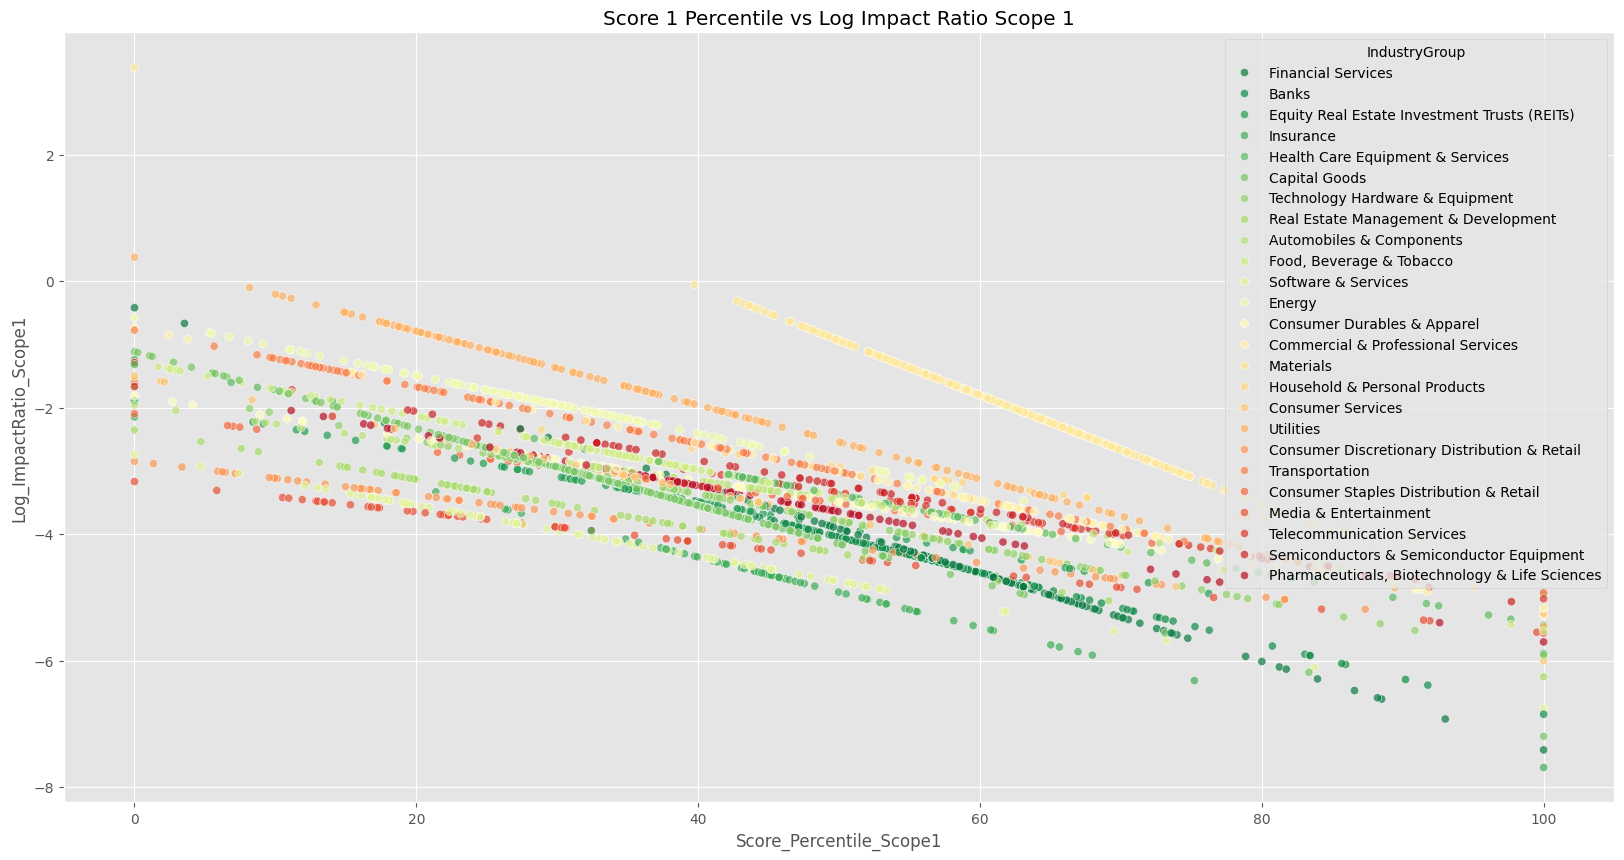

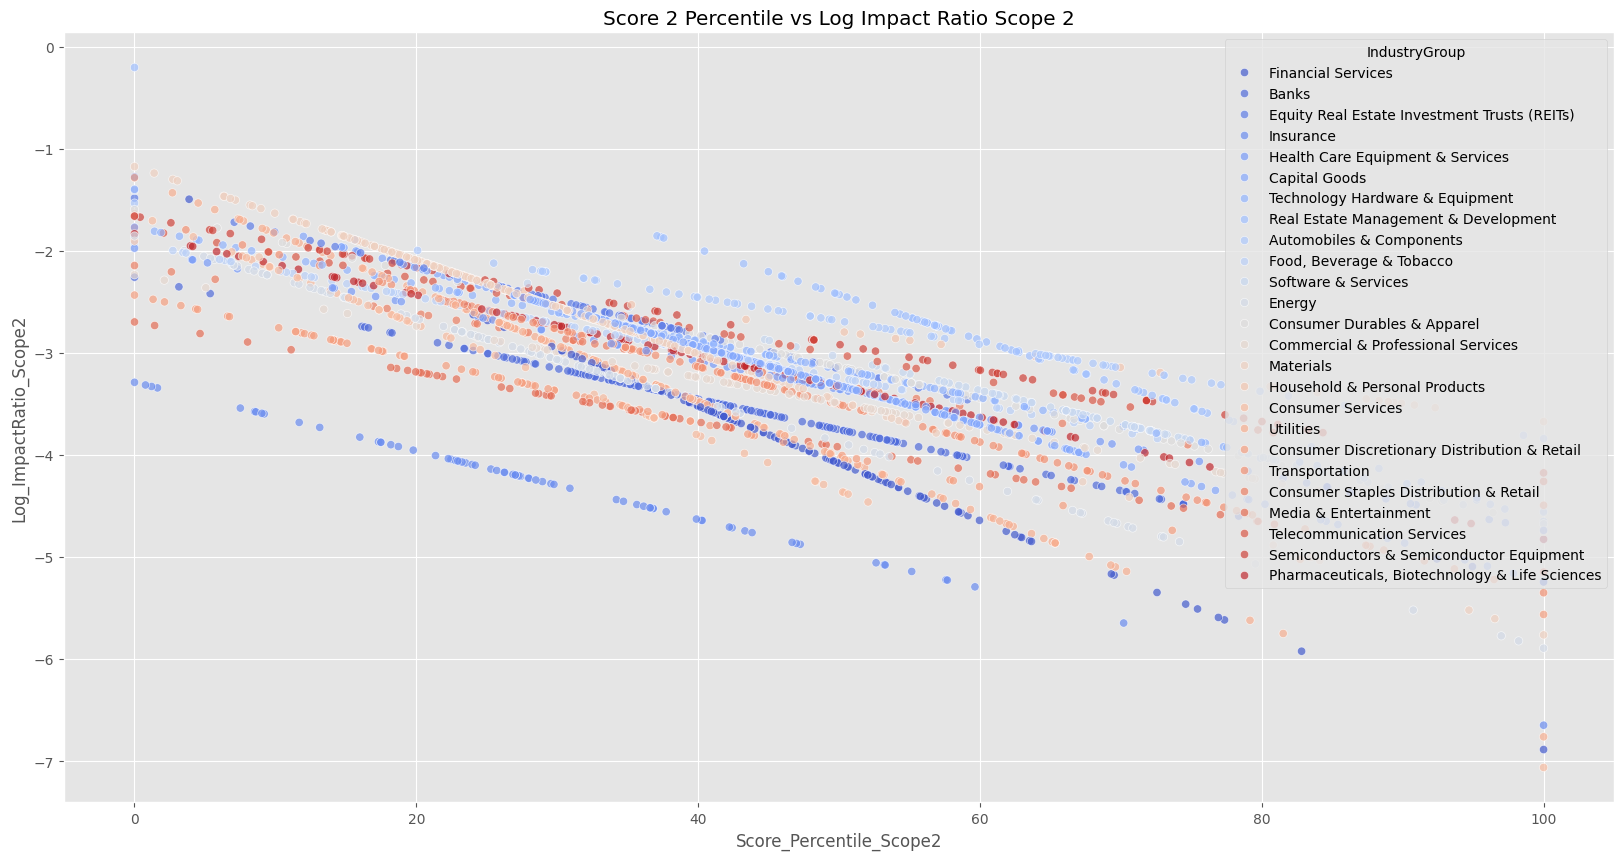

In [383]:
plot_scatterplot(
    df,
    x="Score_Percentile_Scope1",
    y="Log_ImpactRatio_Scope1",
    hue="IndustryGroup",
    title="Score 1 Percentile vs Log Impact Ratio Scope 1",
    palette=order_colors_scope1,
)

plot_scatterplot(
    df,
    x="Score_Percentile_Scope2",
    y="Log_ImpactRatio_Scope2",
    hue="IndustryGroup",
    title="Score 2 Percentile vs Log Impact Ratio Scope 2",
    palette=order_colors_scope2,
)

As desired, diagonal lines from top left to bottom right. That means that the higher the impact ratio, the lower the score.

In [384]:
def plot_regression_lines(
    df: "pd.DataFrame",
    x: str,
    y: str,
    hue: str,
    title: str = "Regression Lines",
    palette=None,
) -> None:
    """
    Plot regression lines for the given columns in the DataFrame.
    """
    sns.lmplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        scatter_kws={"alpha": 0.1},
        palette=palette,
        height=10,
        aspect=2,
    )
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

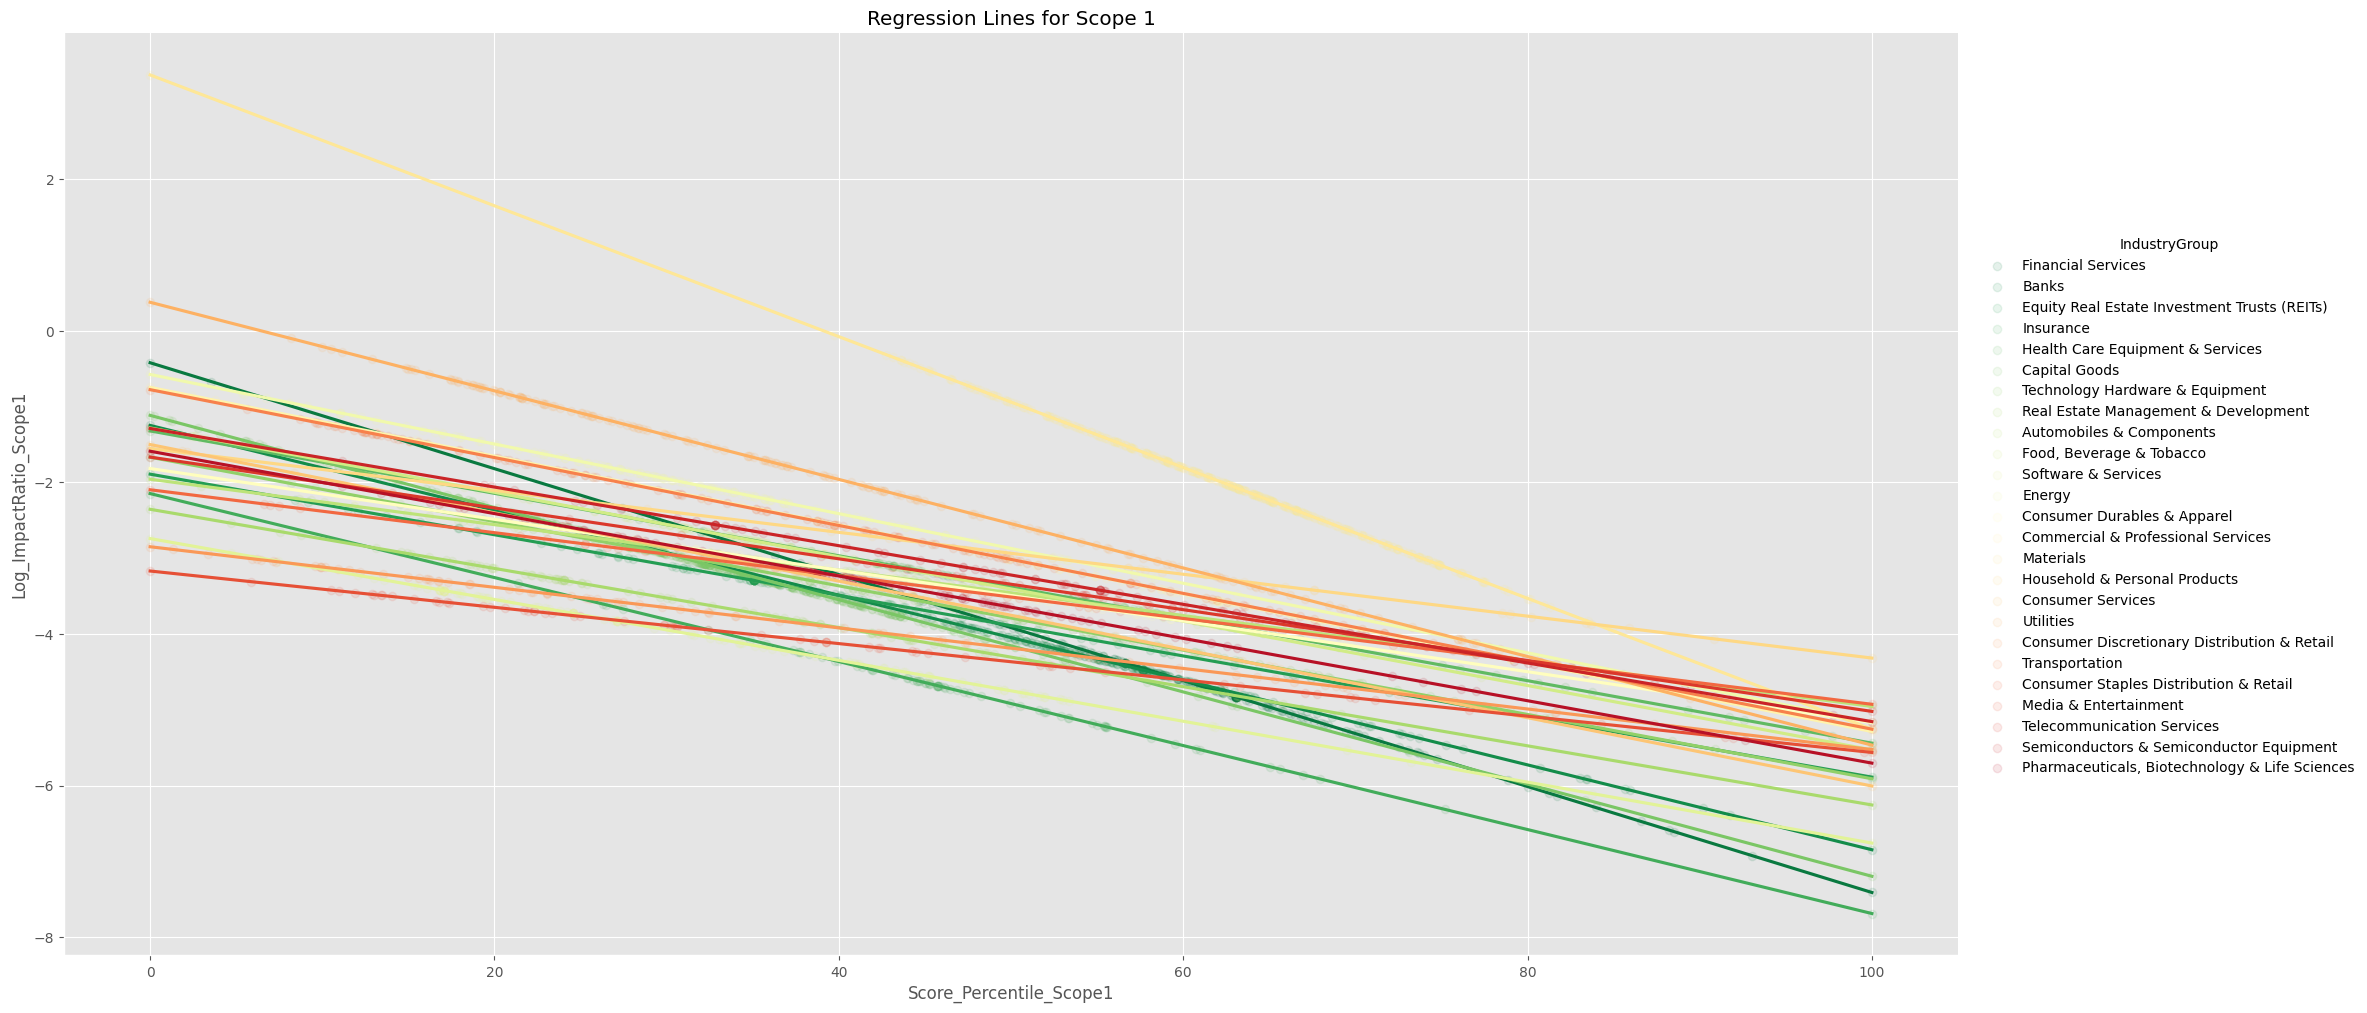

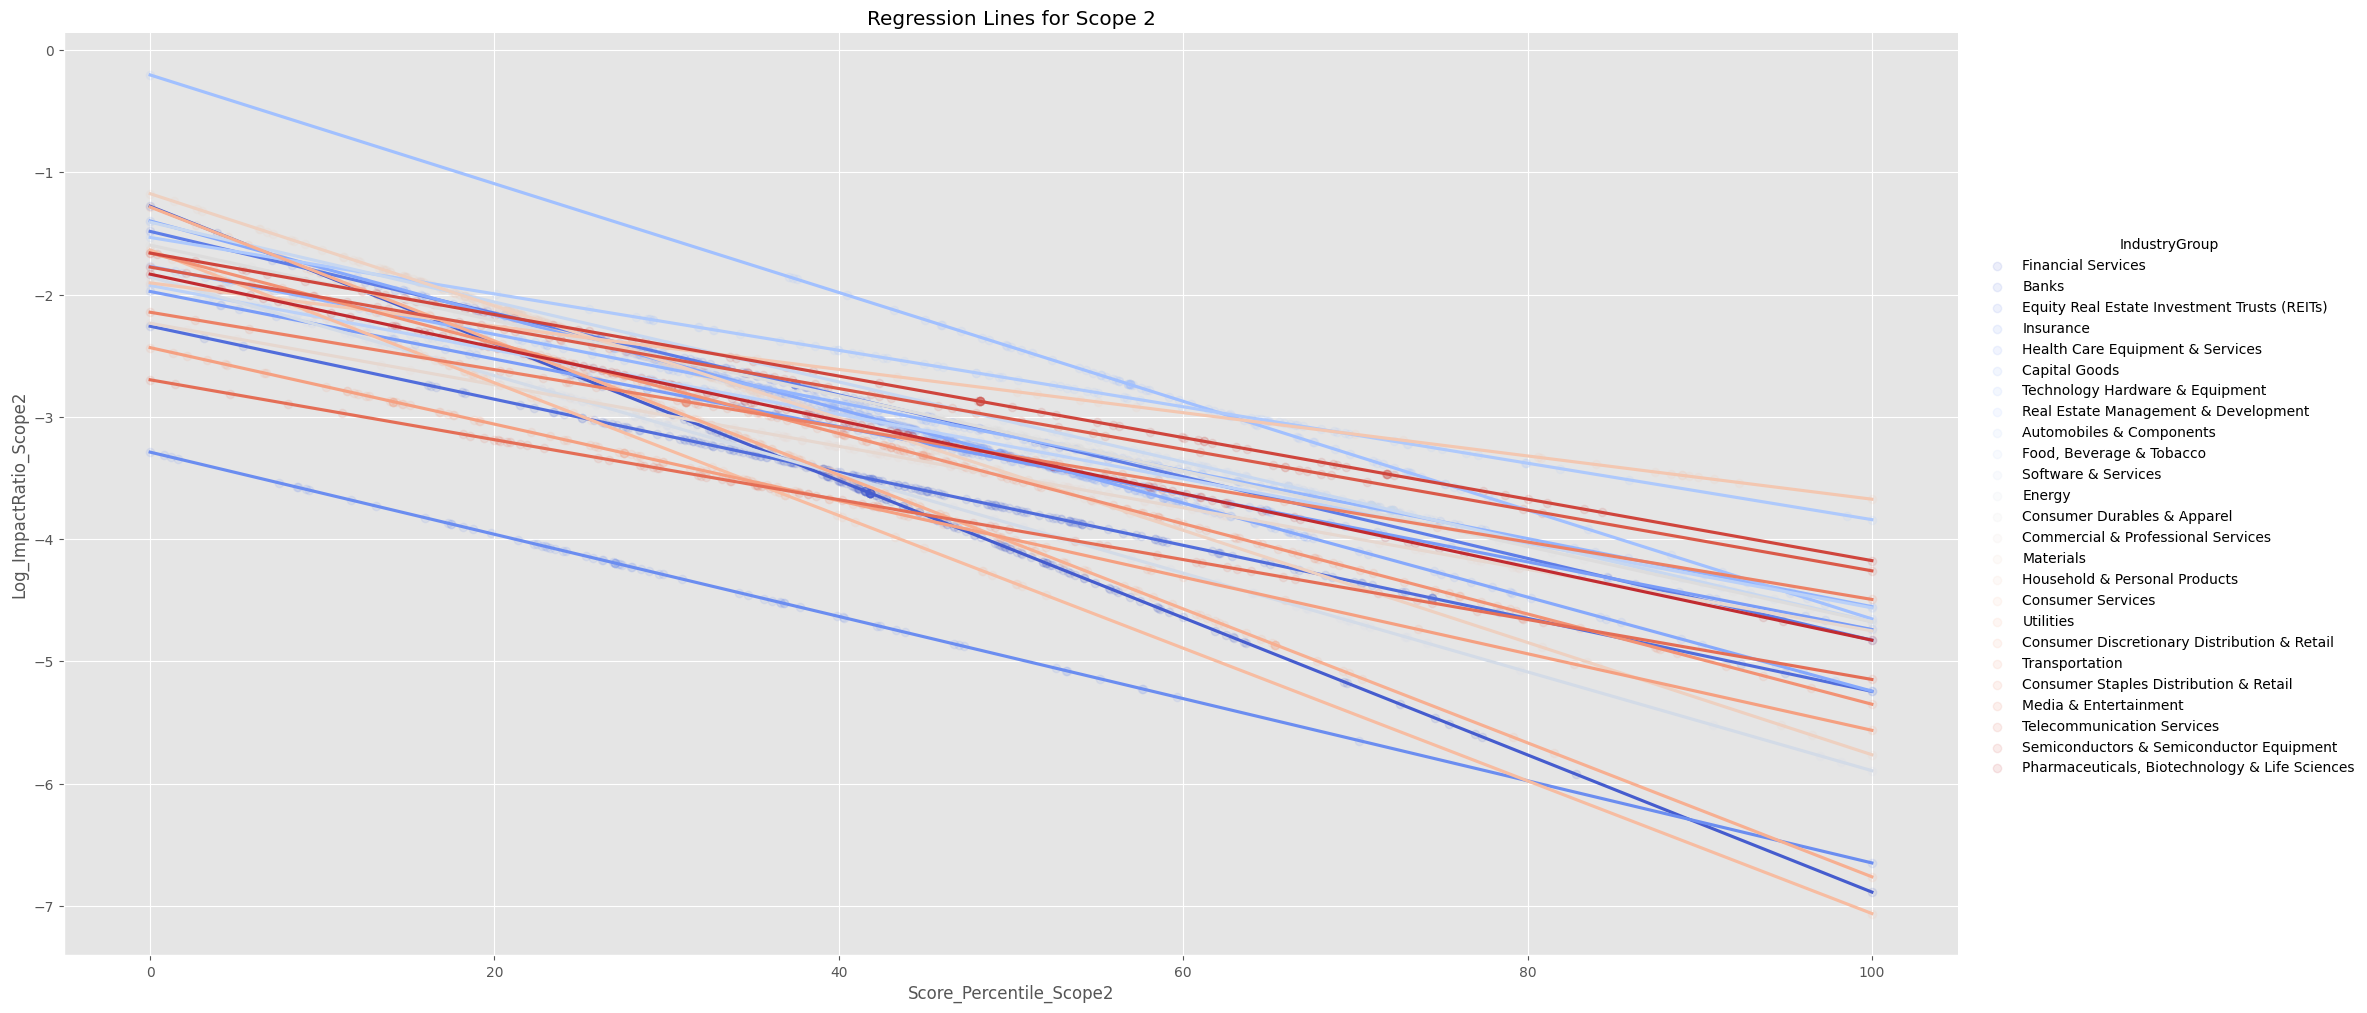

In [385]:
plot_regression_lines(
    df,
    x="Score_Percentile_Scope1",
    y="Log_ImpactRatio_Scope1",
    hue="IndustryGroup",
    title="Regression Lines for Scope 1",
    palette=order_colors_scope1,
)

plot_regression_lines(
    df,
    x="Score_Percentile_Scope2",
    y="Log_ImpactRatio_Scope2",
    hue="IndustryGroup",
    title="Regression Lines for Scope 2",
    palette=order_colors_scope2,
)

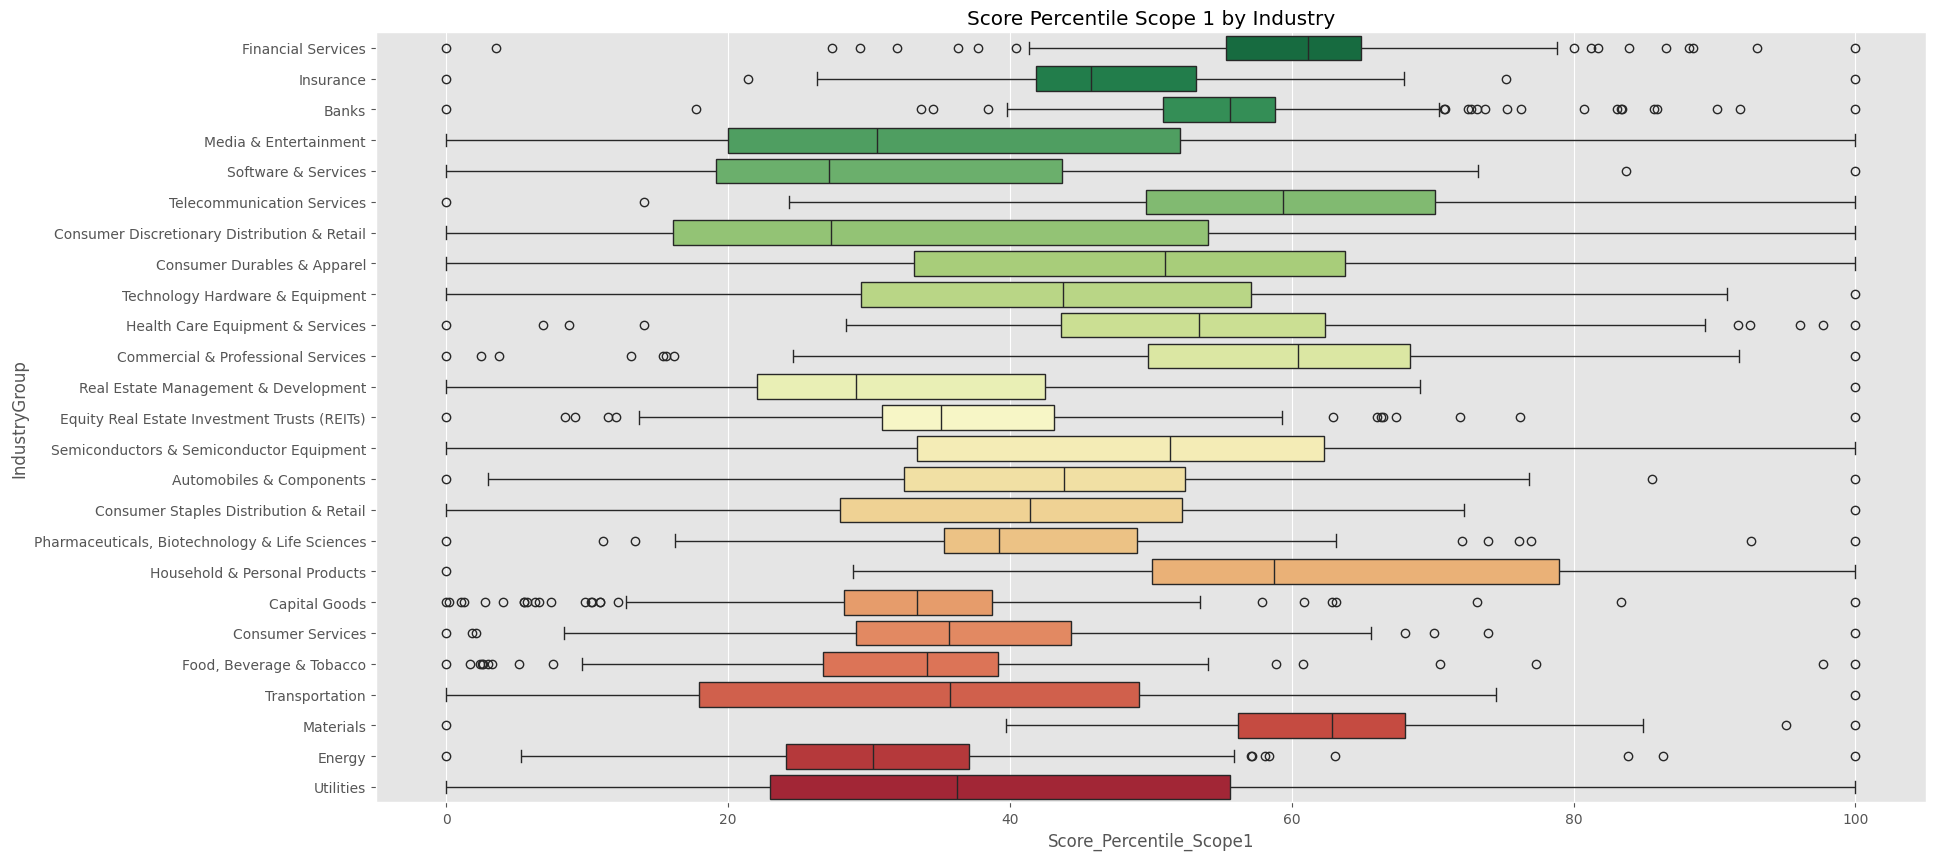

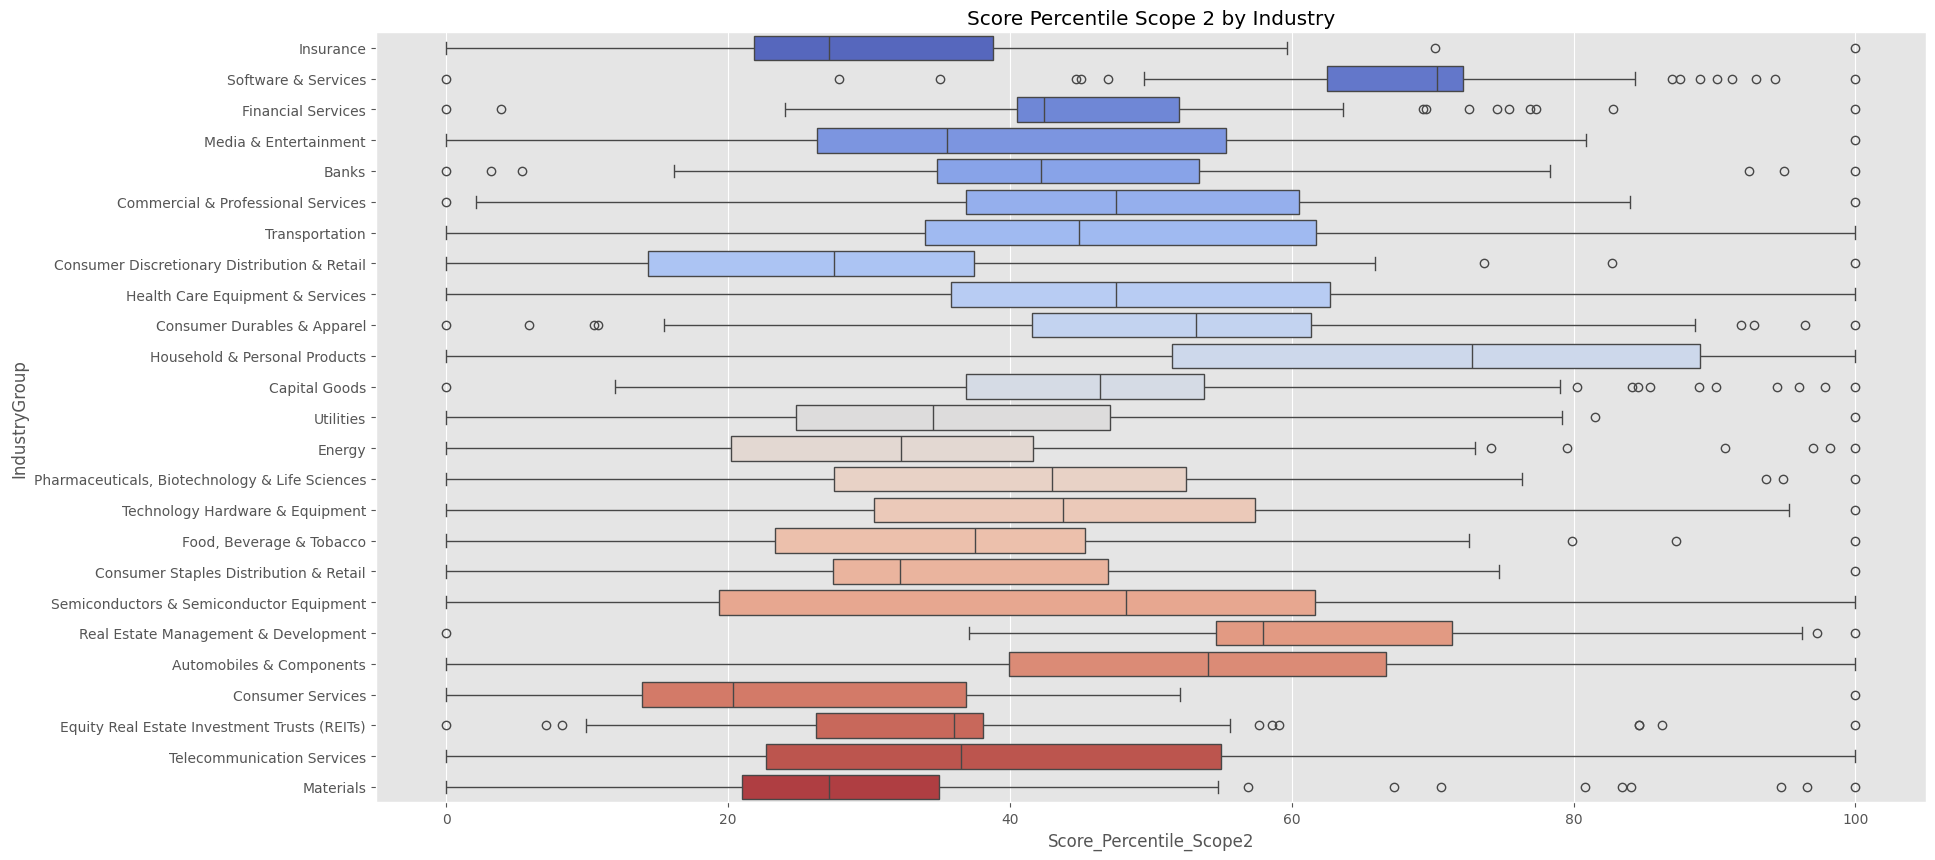

In [ ]:
plot_boxplot(
    df,
    column="Score_Percentile_Scope1",
    hue="IndustryGroup",
    order=order_scope1[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope1,
    title="Score Percentile Scope 1 by Industry",
)
plot_boxplot(
    df,
    column="Score_Percentile_Scope2",
    hue="IndustryGroup",
    order=order_scope2[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope2,
    title="Score Percentile Scope 2 by Industry",
)

- All scores are between 0 and 100, no matter the industry
- Companies with the same impact ratio have different scores
- What happen when a new company has more emissions in the industry? Should we recalibrate?

**Approach 2: Weighted by global percentile**

Although I read that S&P scores cannot be compared across industries, I think it makes sense that a company that has a high impact ratio in an industry with low impact ratios is worse than a company with the same impact ratio in an industry with high impact ratios.

In [386]:
def score_percentile_global(df, column):
    """Score based on percentile in the whole dataset."""
    return 100 * (
        1 - (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    )

In [ ]:
combination_weight = 0.4  # Weight for the industry score

df["Score_Weighted_Scope1"] = df[
    "Score_Percentile_Scope1"
] * combination_weight + score_percentile_global(df, "Log_ImpactRatio_Scope1") * (
    1 - combination_weight
)

df["Score_Weighted_Scope2"] = df[
    "Score_Percentile_Scope2"
] * combination_weight + score_percentile_global(df, "Log_ImpactRatio_Scope2") * (
    1 - combination_weight
)

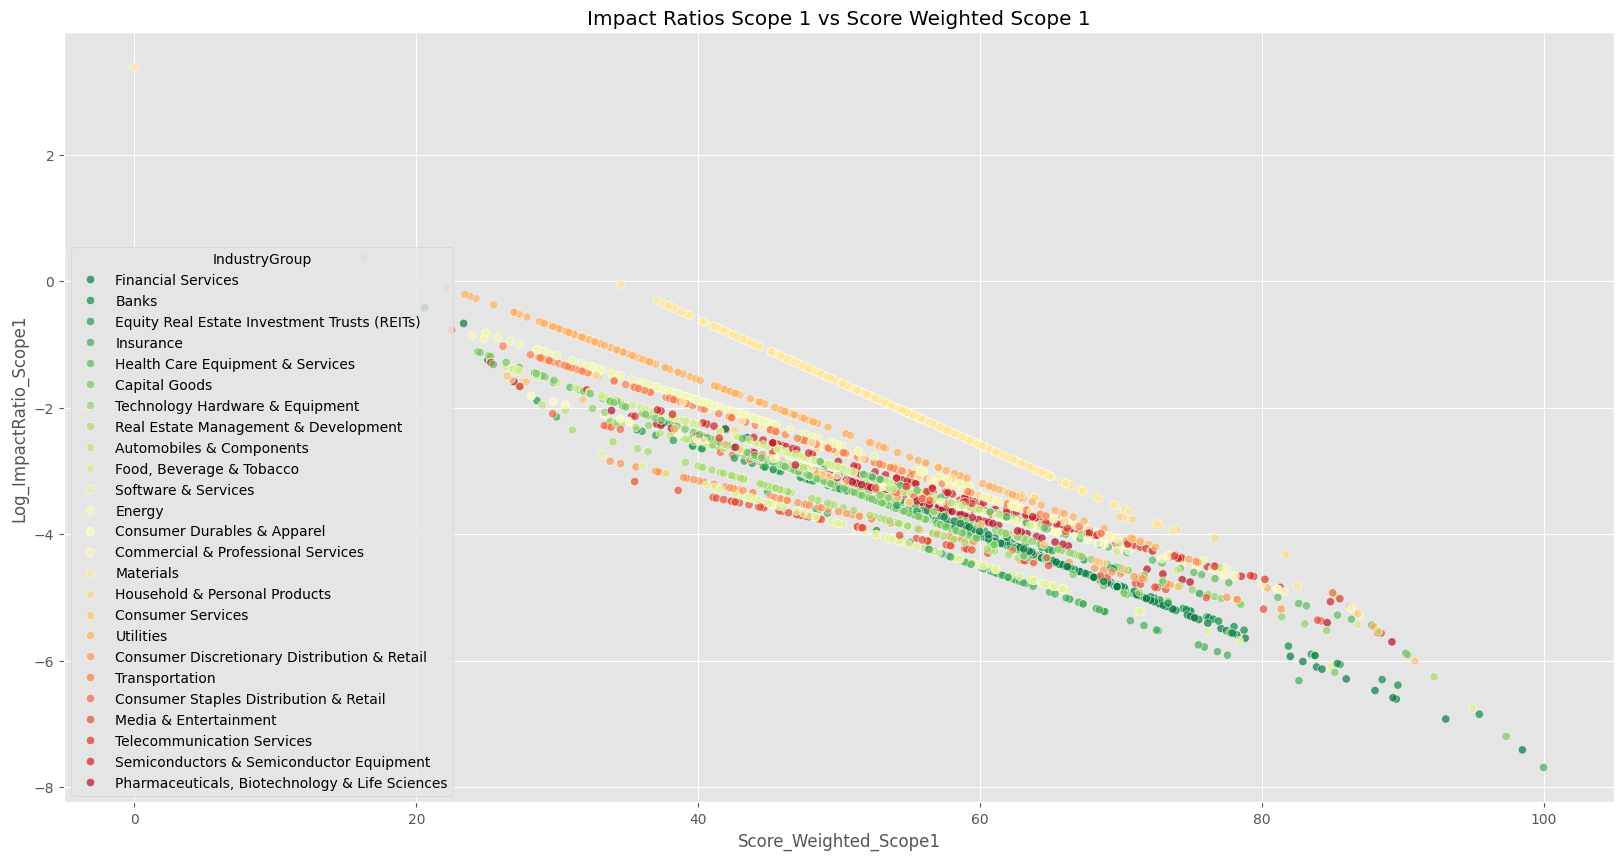

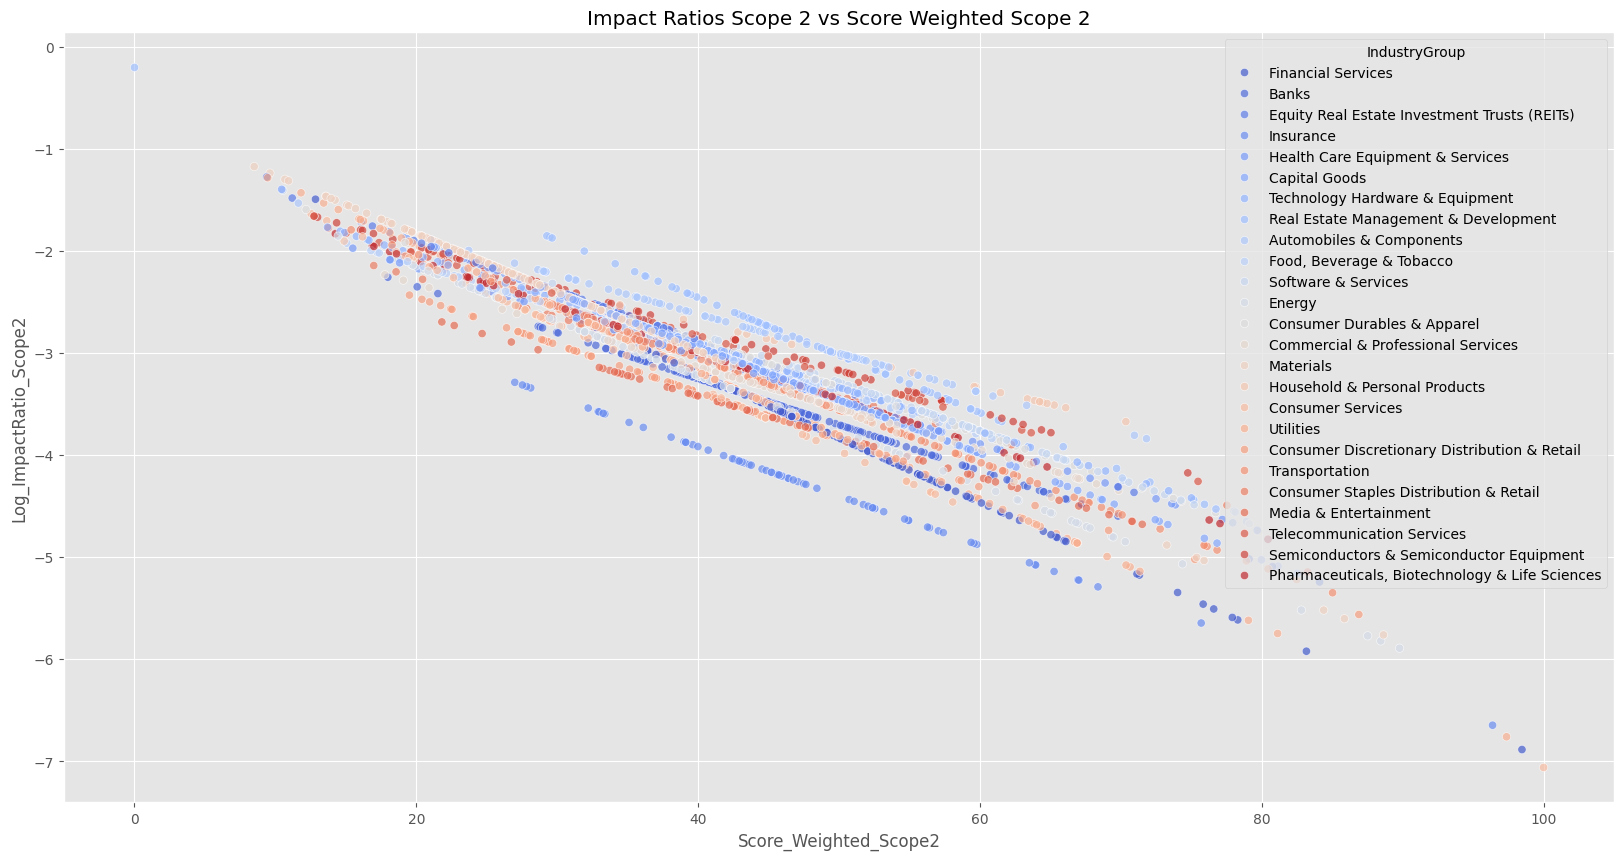

In [388]:
plot_scatterplot(
    df,
    x="Score_Weighted_Scope1",
    y="Log_ImpactRatio_Scope1",
    hue="IndustryGroup",
    title="Impact Ratios Scope 1 vs Score Weighted Scope 1",
    palette=order_colors_scope1,
)

plot_scatterplot(
    df,
    x="Score_Weighted_Scope2",
    y="Log_ImpactRatio_Scope2",
    hue="IndustryGroup",
    title="Impact Ratios Scope 2 vs Score Weighted Scope 2",
    palette=order_colors_scope2,
)

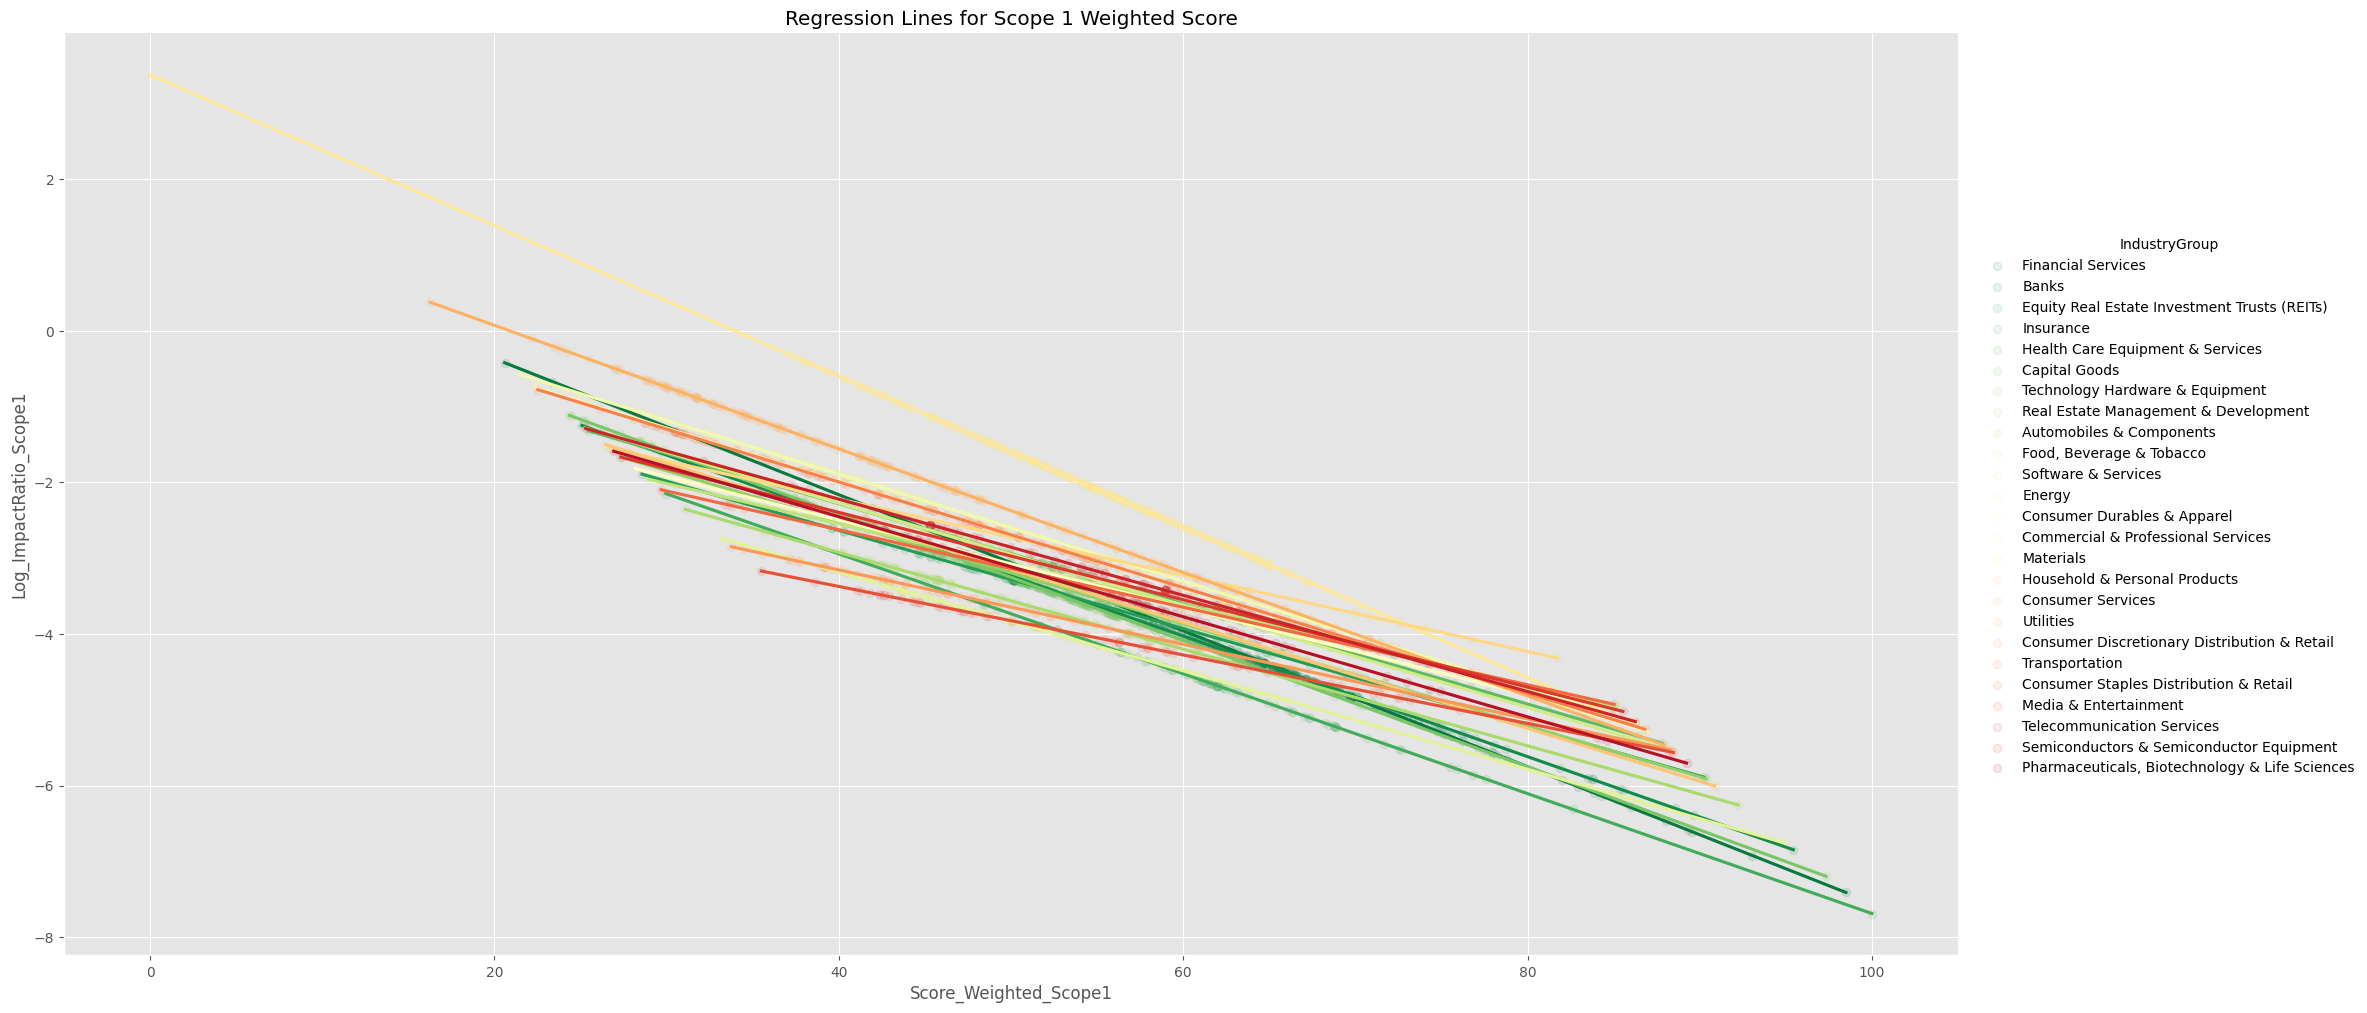

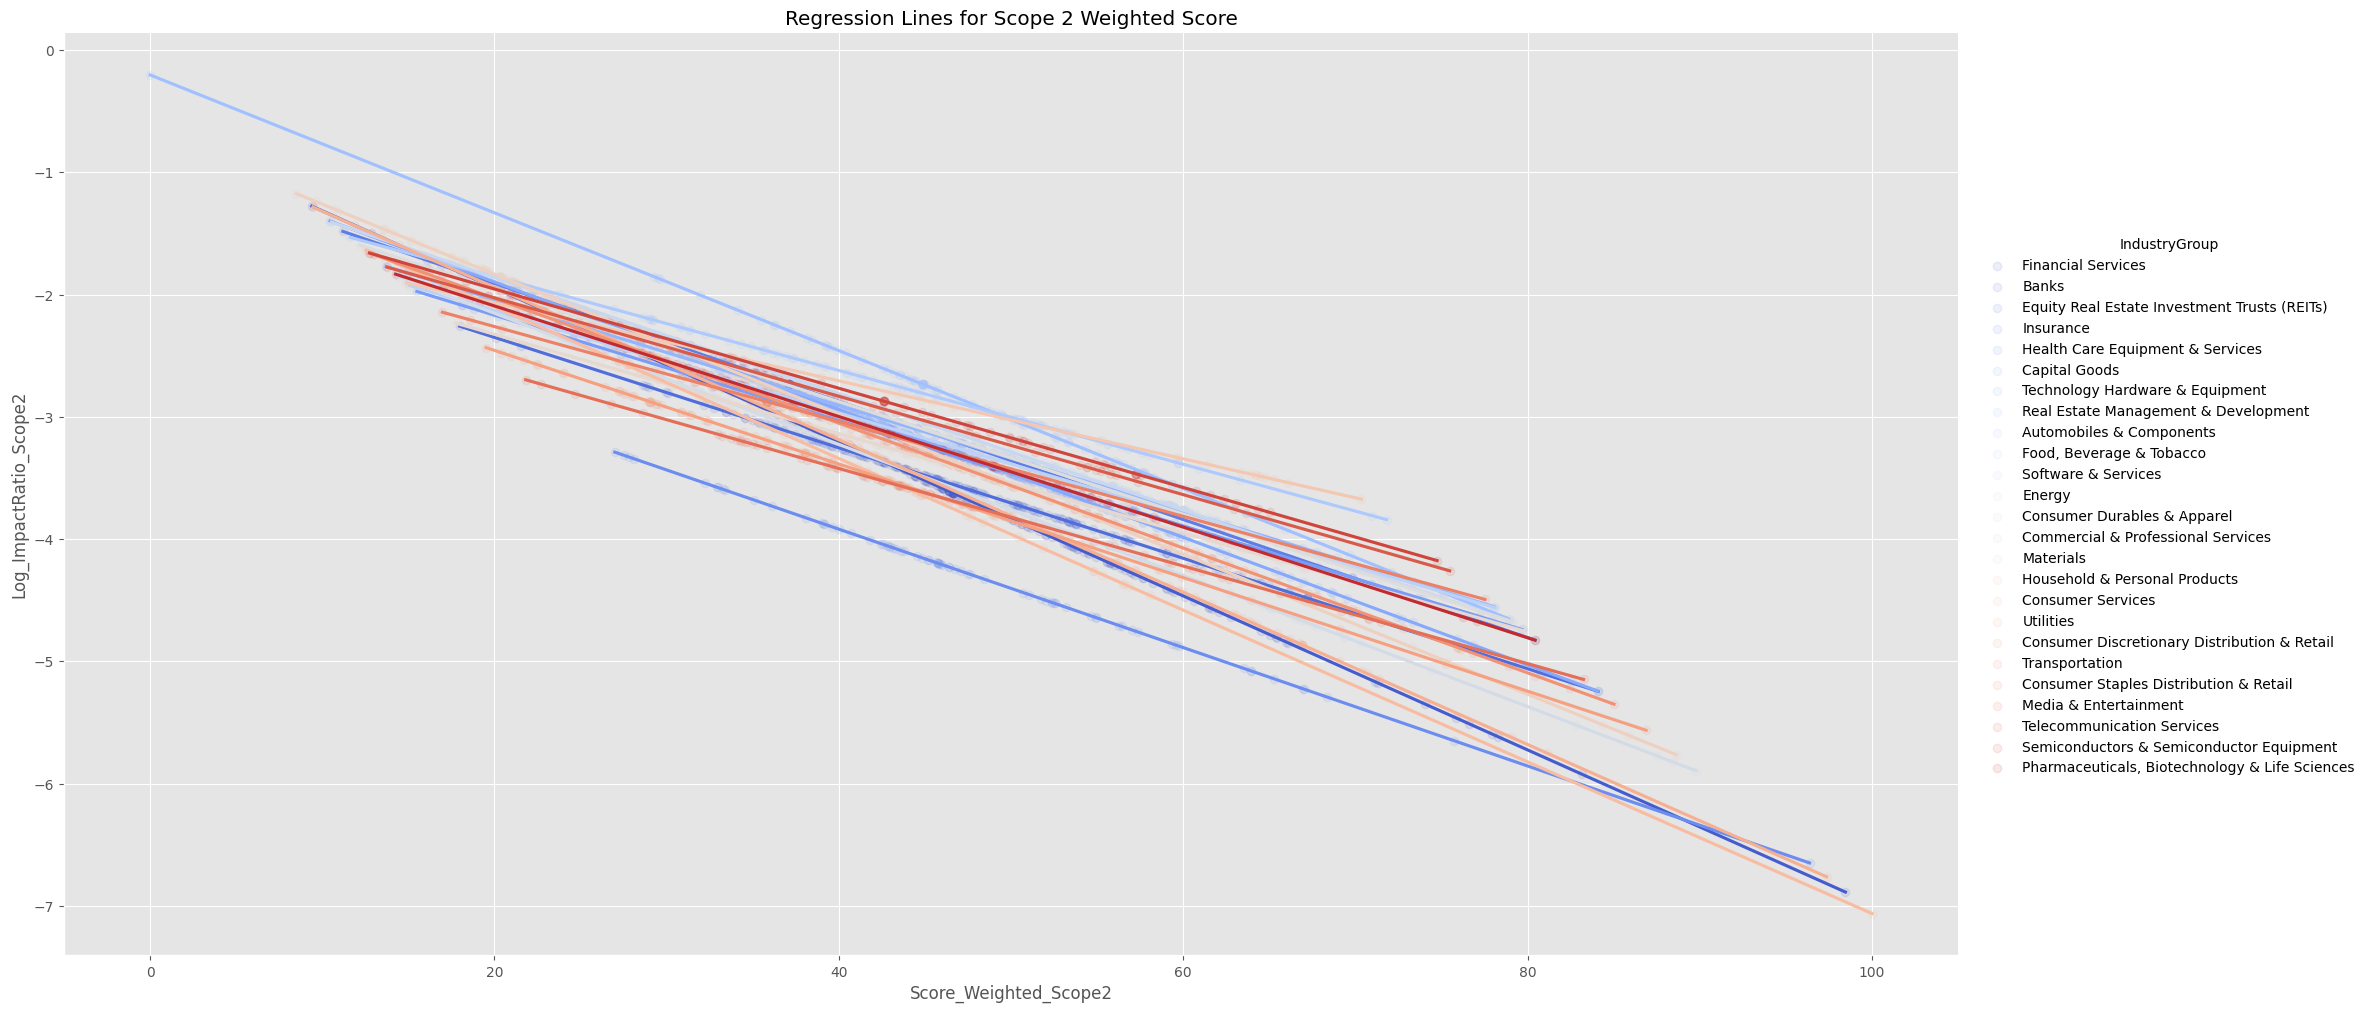

In [389]:
plot_regression_lines(
    df,
    x="Score_Weighted_Scope1",
    y="Log_ImpactRatio_Scope1",
    hue="IndustryGroup",
    title="Regression Lines for Scope 1 Weighted Score",
    palette=order_colors_scope1,
)
plot_regression_lines(
    df,
    x="Score_Weighted_Scope2",
    y="Log_ImpactRatio_Scope2",
    hue="IndustryGroup",
    title="Regression Lines for Scope 2 Weighted Score",
    palette=order_colors_scope2,
)

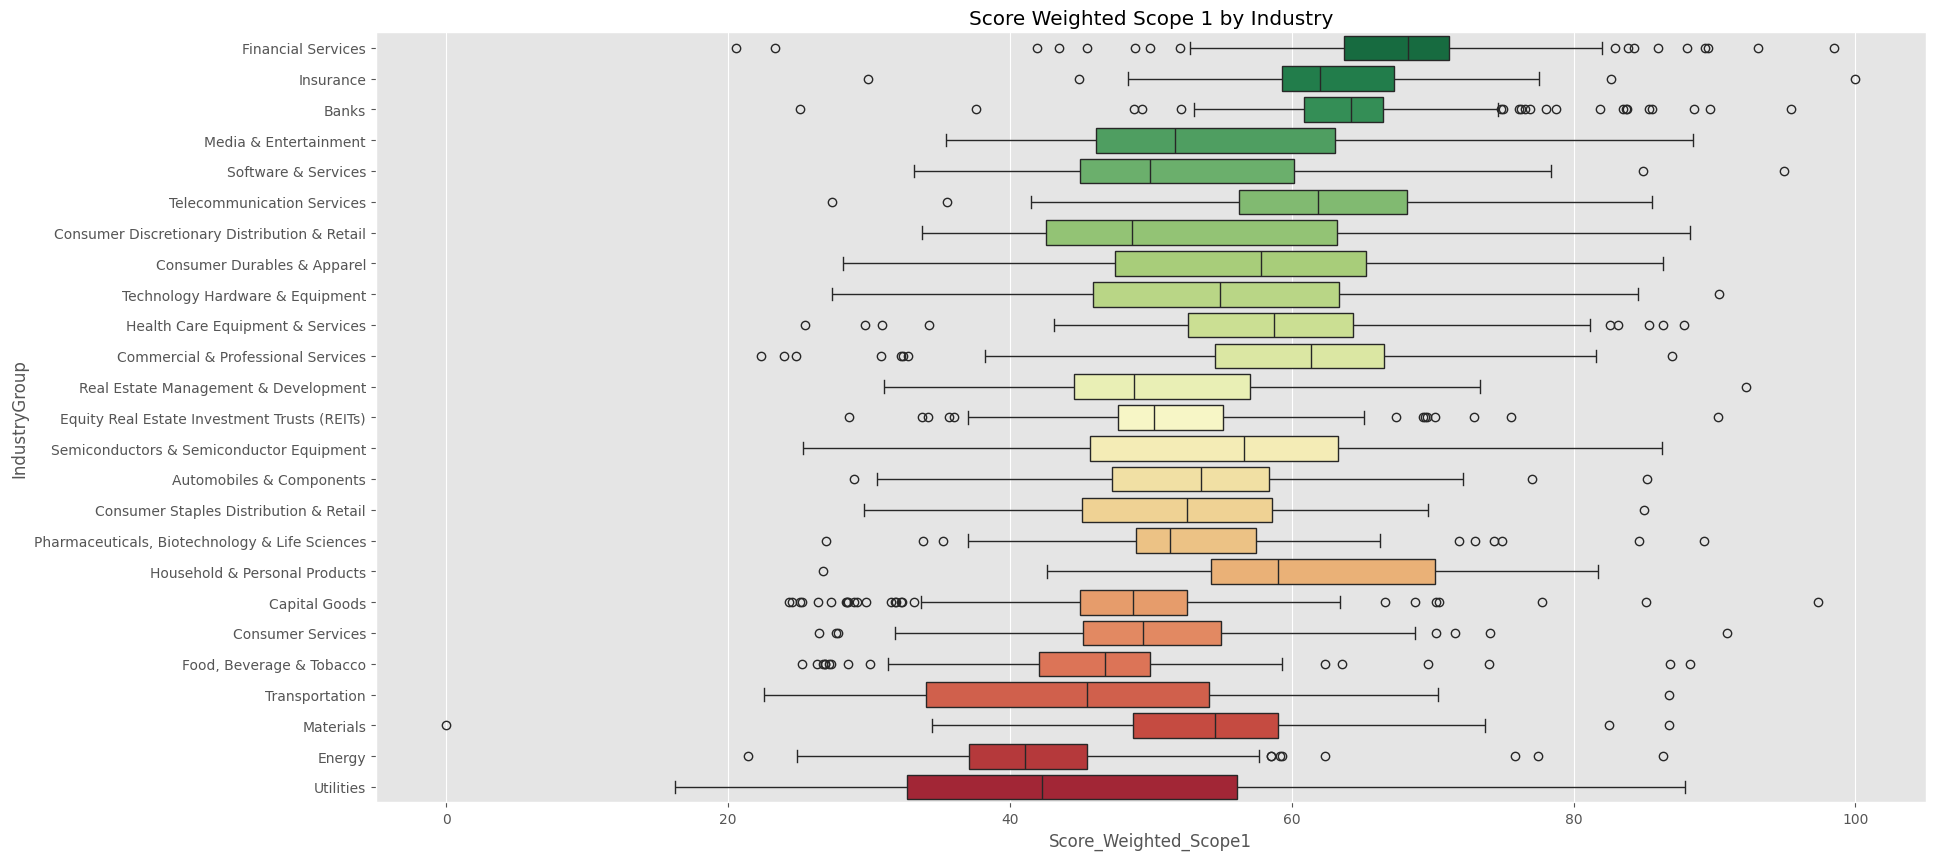

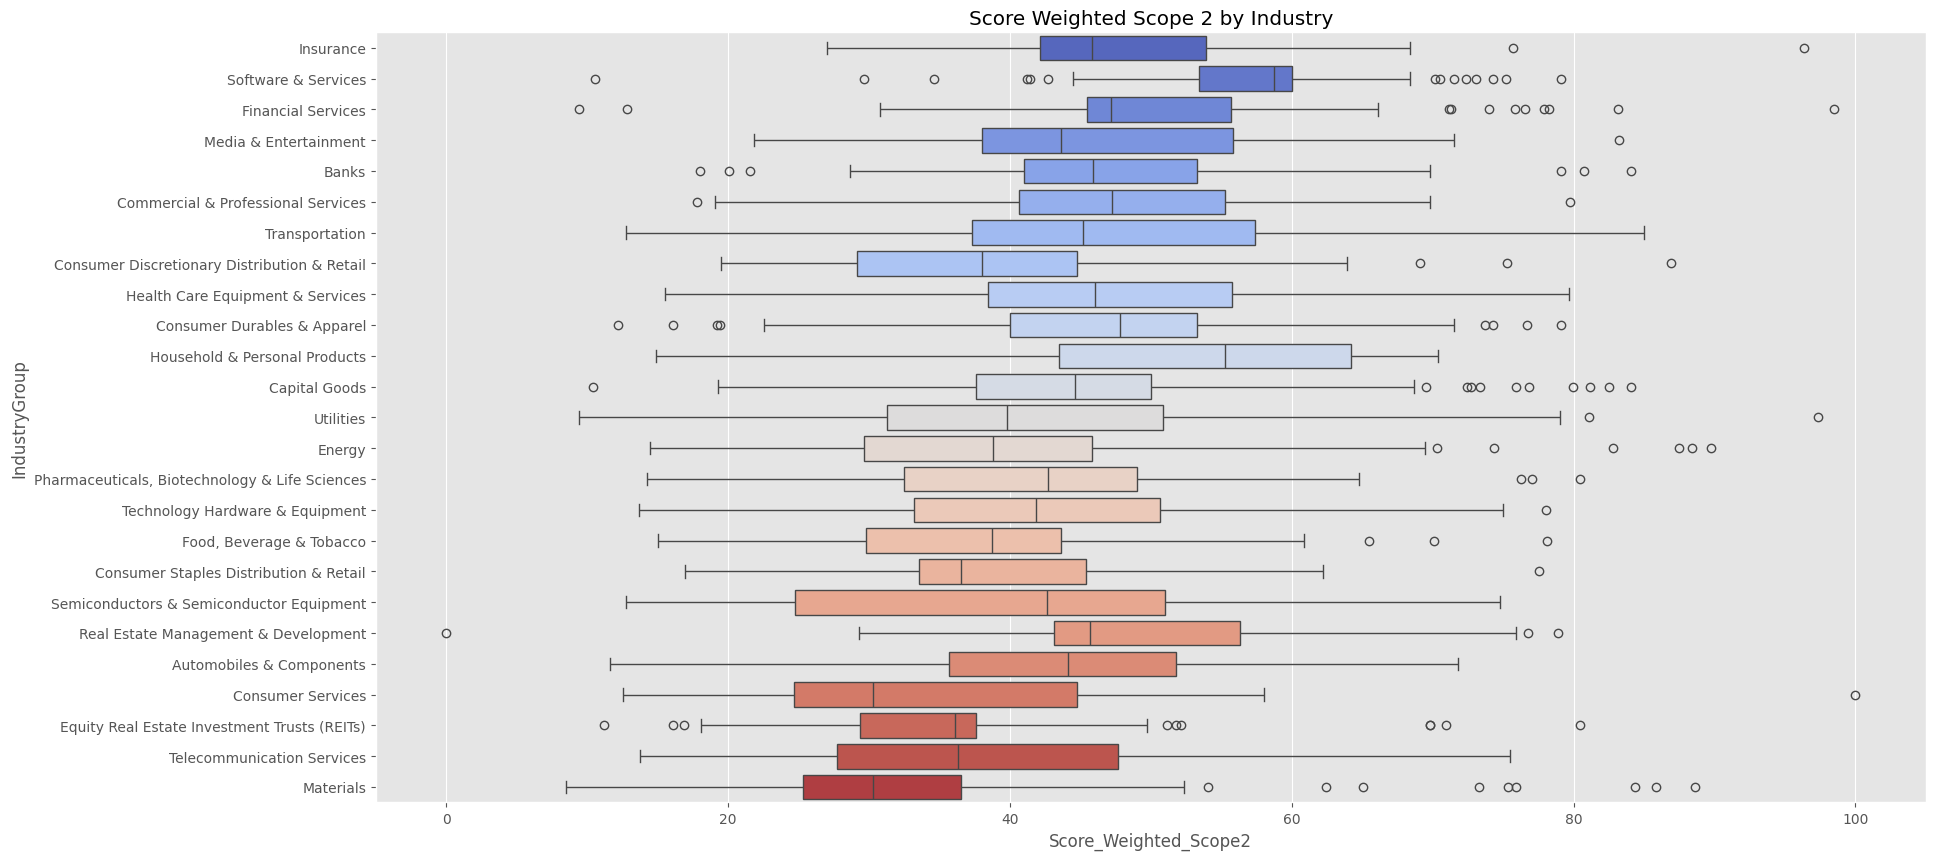

In [ ]:
plot_boxplot(
    df,
    column="Score_Weighted_Scope1",
    hue="IndustryGroup",
    order=order_scope1[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope1,
    title="Score Weighted Scope 1 by Industry",
)
plot_boxplot(
    df,
    column="Score_Weighted_Scope2",
    hue="IndustryGroup",
    order=order_scope2[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope2,
    title="Score Weighted Scope 2 by Industry",
)

- Now industries with higher impact ratios have lower scores
- But companies can reach still reach higher scores, no matter the industry

- I should ensure that any company can reach a score of 100. How?

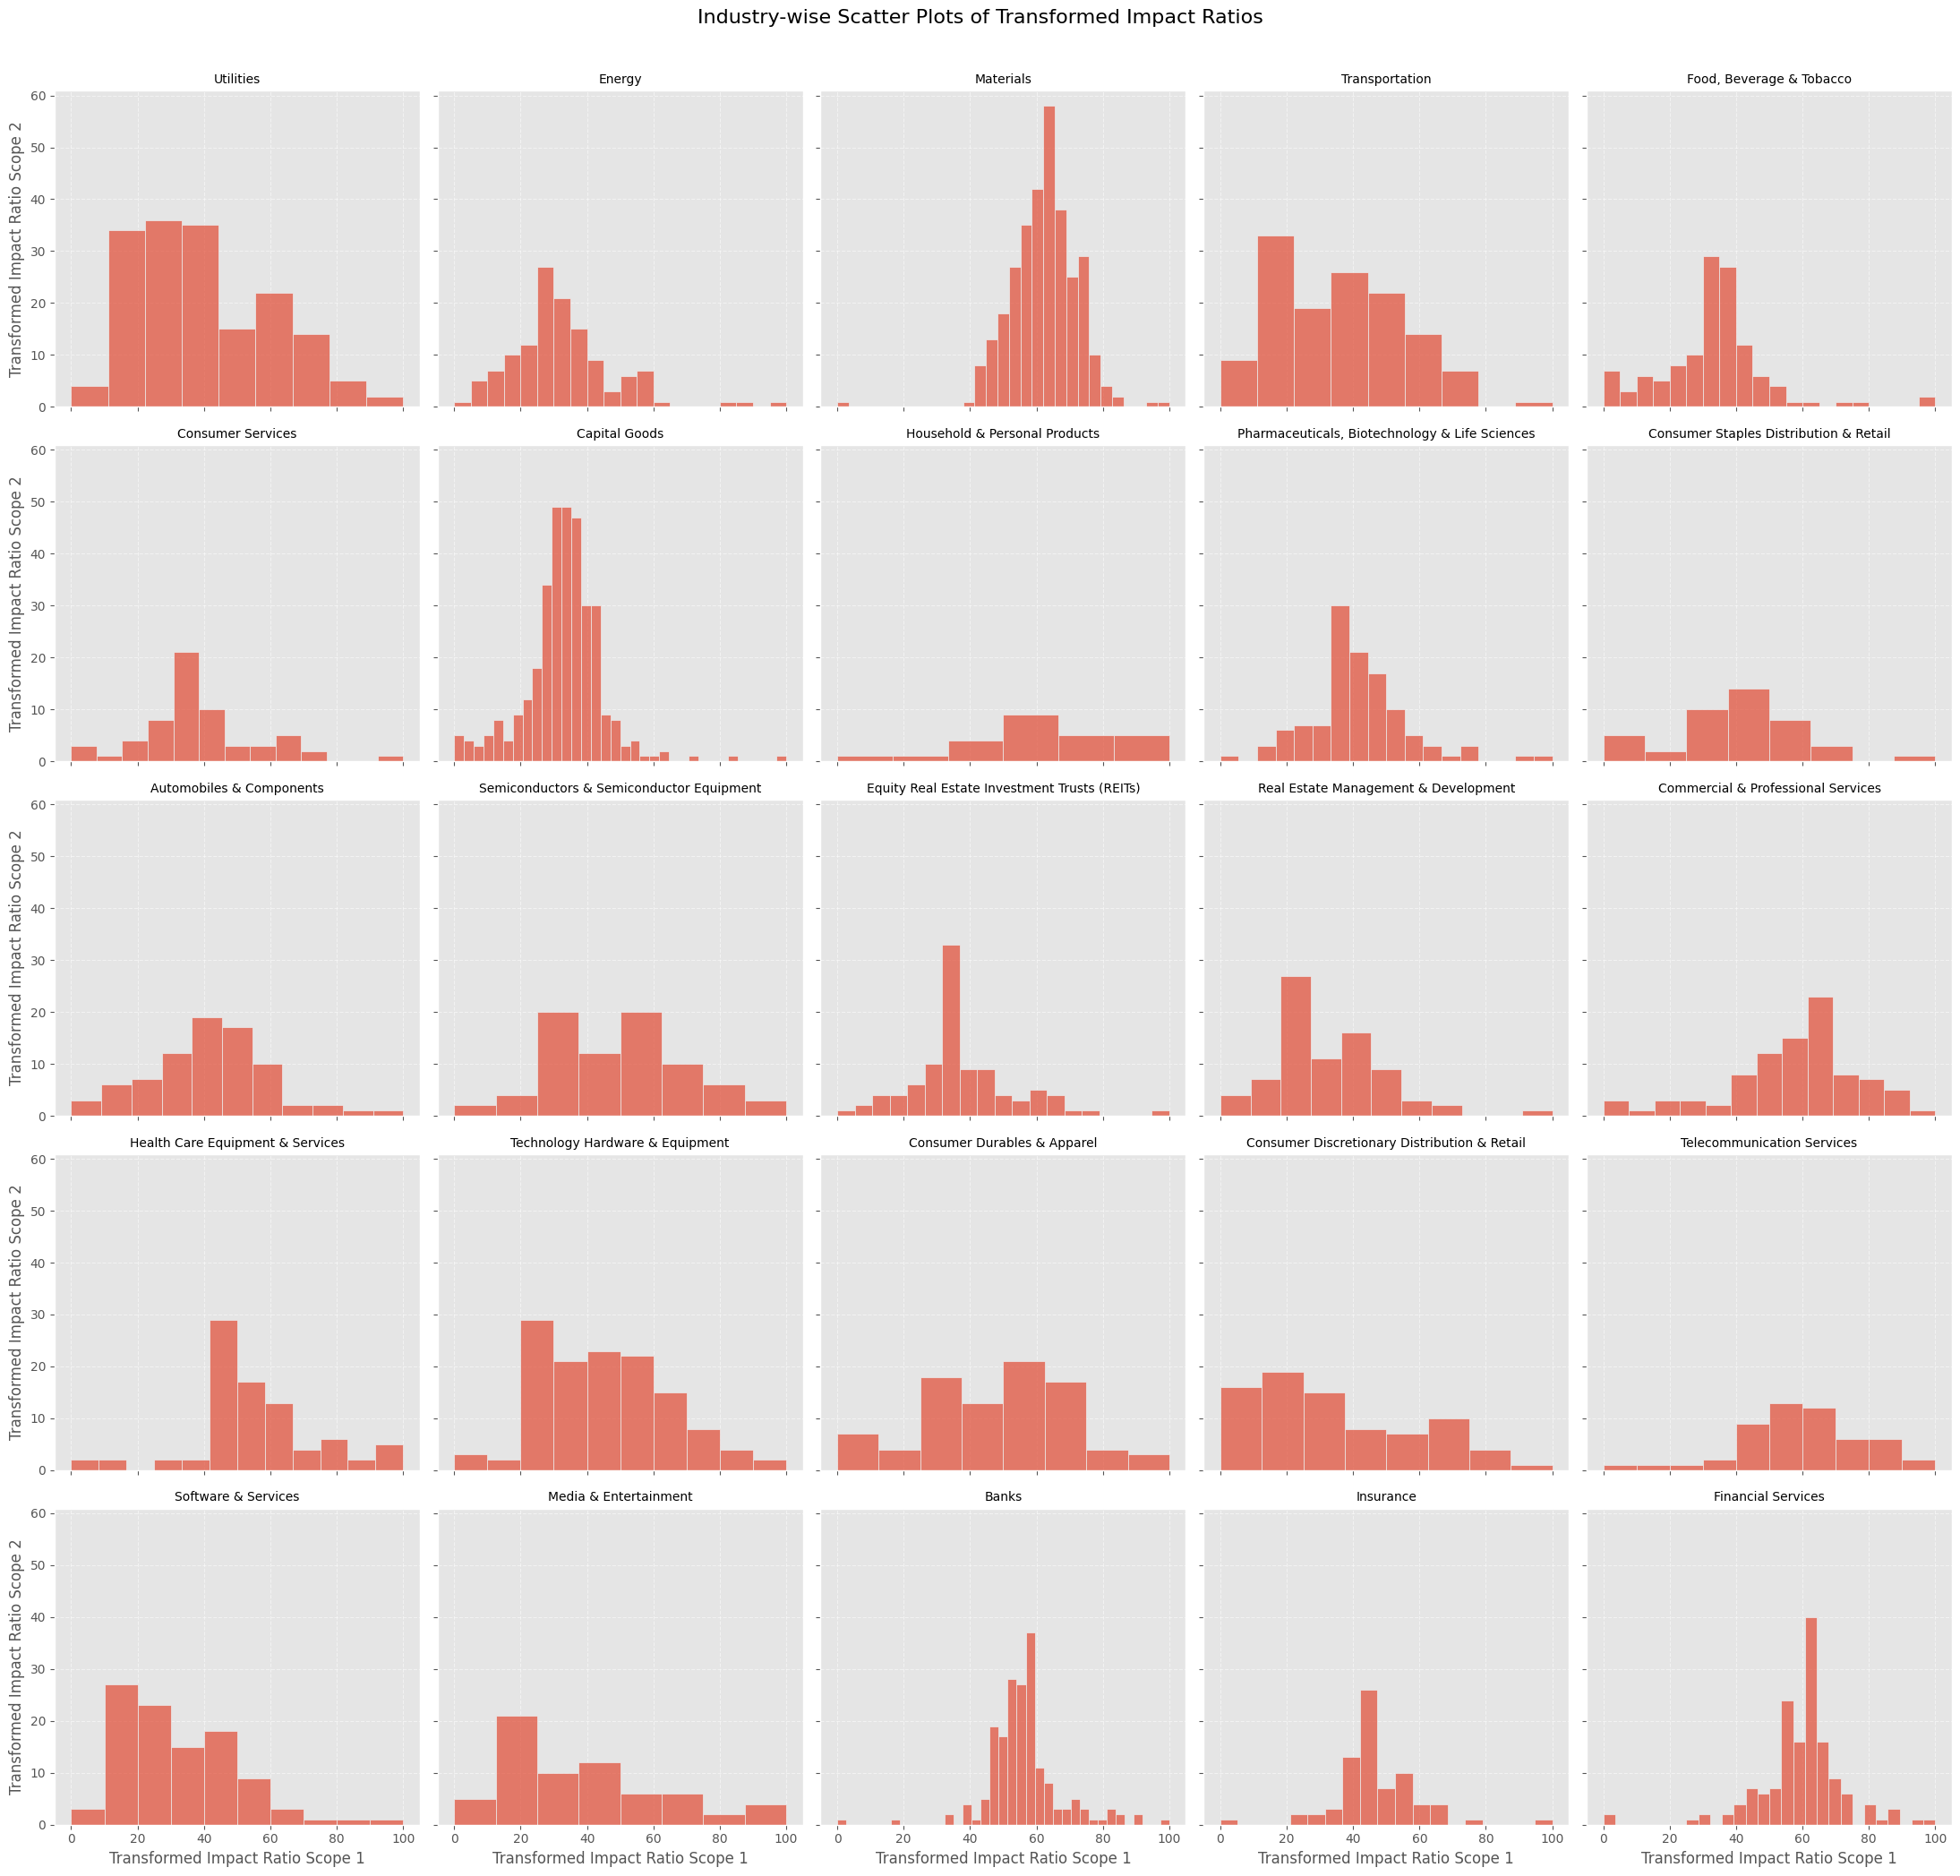

In [391]:
# Improved 5x5 grid of scatter plots for each industry
n_rows = 5
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 22), sharex=True, sharey=True)
for i, industry in enumerate(order_scope1):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    sns.histplot(
        # data=df[df["IndustryGroup"] == industry],
        # x="Log_ImpactRatio_Scope1",
        data=df[df["IndustryGroup"] == industry],
        x="Score_Percentile_Scope1",
        ax=ax,
        # hue="IndustryGroup",
        # palette=[order_colors[-i]],
        alpha=0.7,
        legend=False,
    )
    # sns.scatterplot(
    #     data=df[df["IndustryGroup"] == industry],
    #     x="Log_ImpactRatio_Scope1",
    #     y="Log_ImpactRatio_Scope2",
    #     ax=ax,
    #     hue="IndustryGroup",
    #     palette=[order_colors[-i]],
    #     alpha=0.7,
    #     s=40,  # marker size
    #     legend=False,
    # )
    ax.set_title(industry, fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)
    if row == n_rows - 1:
        ax.set_xlabel("Transformed Impact Ratio Scope 1")
    else:
        ax.set_xlabel("")
    if col == 0:
        ax.set_ylabel("Transformed Impact Ratio Scope 2")
    else:
        ax.set_ylabel("")

plt.suptitle("Industry-wise Scatter Plots of Transformed Impact Ratios", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

### Other approaches

Z-score normalization

In [445]:
def score_z_industry(df, column, industry_column="IndustryGroup"):
    """Score based on percentile in the industry."""
    # This is just a simple min-max normalization
    df_group = df.groupby(industry_column)[column].transform(
        lambda x: (100 * (x - x.mean()) / (x.std()))
    )
    # Min-max normalization to ensure scores are between 0 and 100
    df_group = (df_group - df_group.min()) / (df_group.max() - df_group.min()) * 100
    return df_group

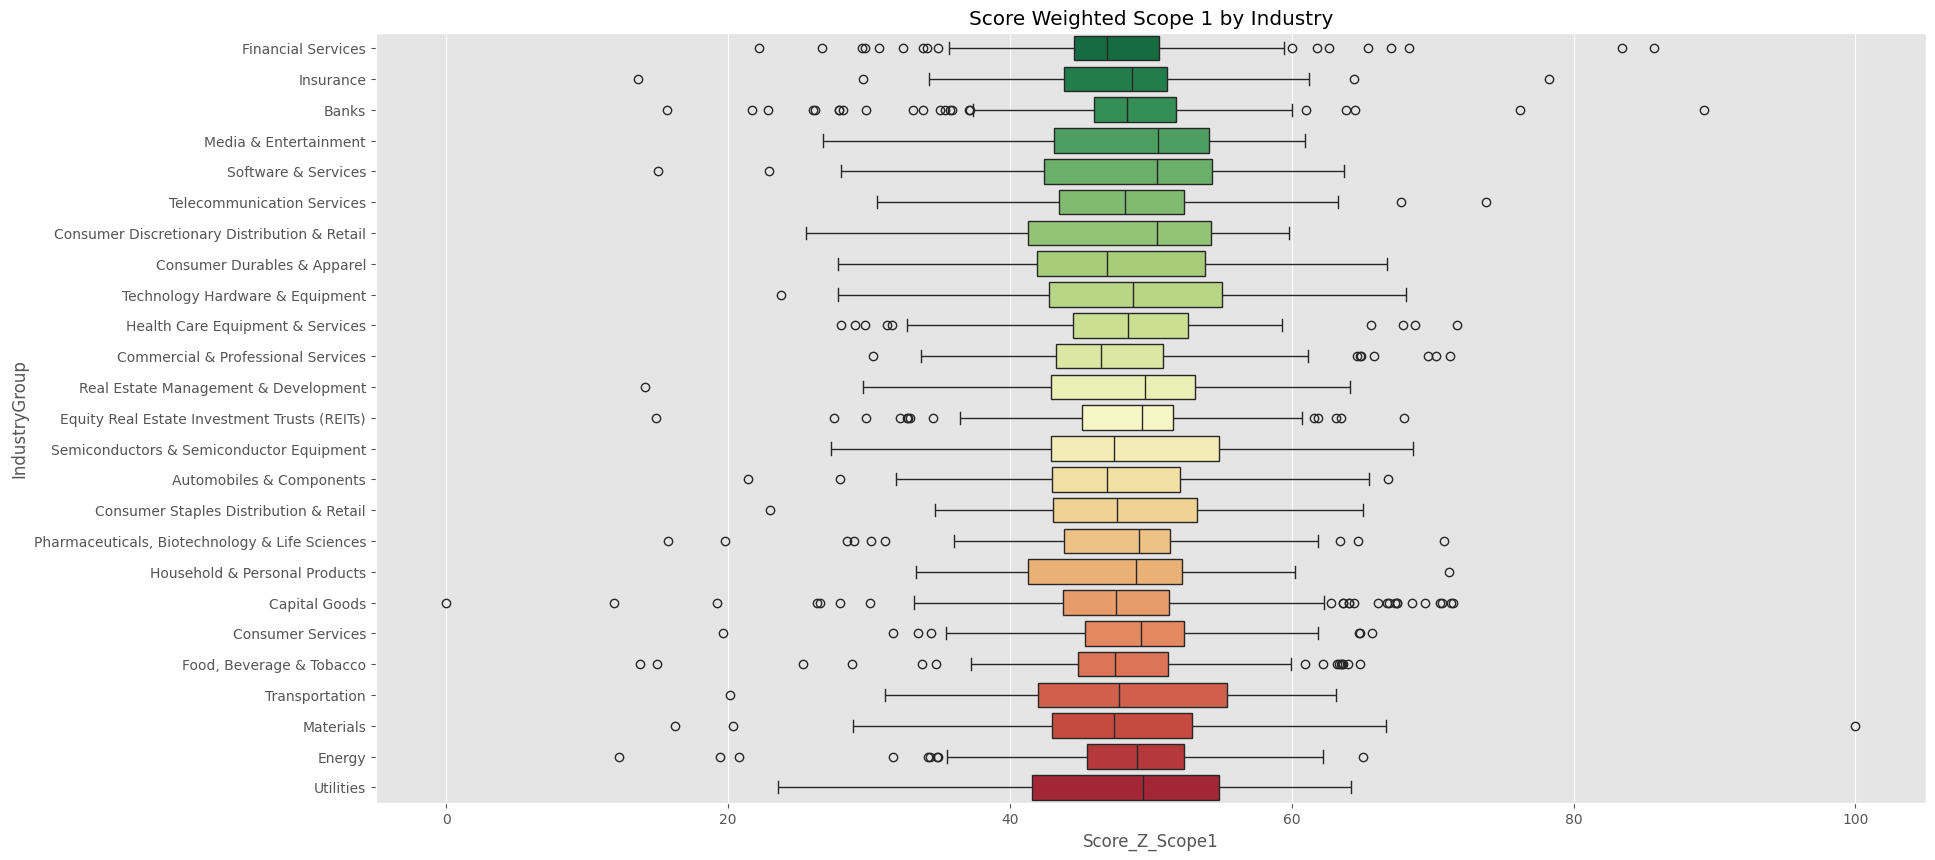

In [ ]:
# Z-score normalization
df["Score_Z_Scope1"] = score_z_industry(df, "Log_ImpactRatio_Scope1")

plot_boxplot(
    df,
    column="Score_Z_Scope1",
    hue="IndustryGroup",
    order=order_scope1[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope1,
    title="Score Weighted Scope 1 by Industry",
)

- Difficult to obtain high and low scores

Sigmoid

![image.png](sigmoid.png)

In [ ]:
def score_sigmoid_industry(
    df, column, quantile: float = 0.5, industry_column="IndustryGroup"
):
    """Score based on logistic transformation in the industry."""
    # Can be center around the median or any other quantile before transforming
    df_group = df.groupby(industry_column)[column].transform(
        lambda x: 100 / (1 + np.exp(x - x.quantile(quantile)))
    )
    return df_group

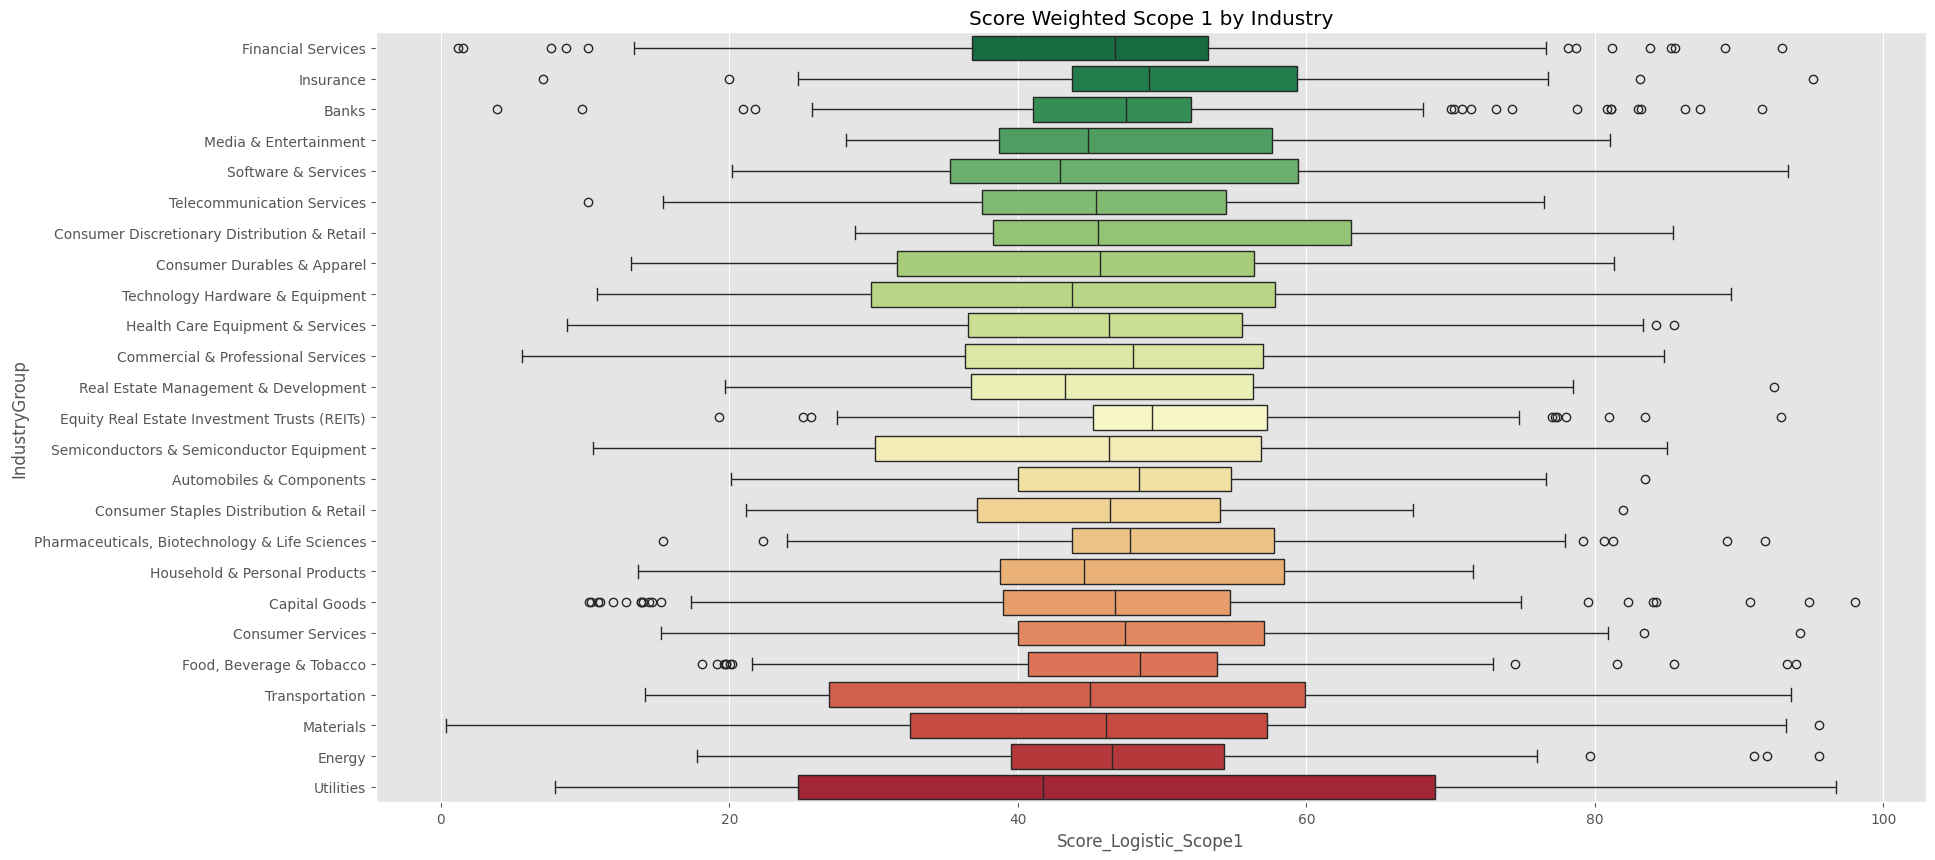

In [ ]:
df["Score_Sigmoid_Scope1"] = score_sigmoid_industry(df, "Log_ImpactRatio_Scope1", 0.4)

plot_boxplot(
    df,
    column="Score_Sigmoid_Scope1",
    hue="IndustryGroup",
    order=order_scope1[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope1,
    title="Score Weighted Scope 1 by Industry",
)

### Scoring the missing values

For the missing values, I will assign a score based on the average of the industry.

A smarter imputation would consider Scope 1 and Scope 2 simultaneously, and maybe other features in the CSA.

In [396]:
avg_scores = df.groupby("IndustryGroup").mean()

In [399]:
def fillna_with_industry_mean(df, value_column, industry_column="IndustryGroup"):
    """
    Fill NA values in `value_column` with the mean of the corresponding industry.
    """
    return df.groupby(industry_column)[value_column].transform(
        lambda x: x.fillna(x.mean())
    )

In [ ]:
# Adding missing values
df = pd.concat([df, df_nan], axis=0)

# Add mean of industry for missing values
df["Score_Weighted_Scope1"] = fillna_with_industry_mean(df, "Score_Weighted_Scope1")
df["Score_Weighted_Scope2"] = fillna_with_industry_mean(df, "Score_Weighted_Scope2")

Distributions should not change, only less variance

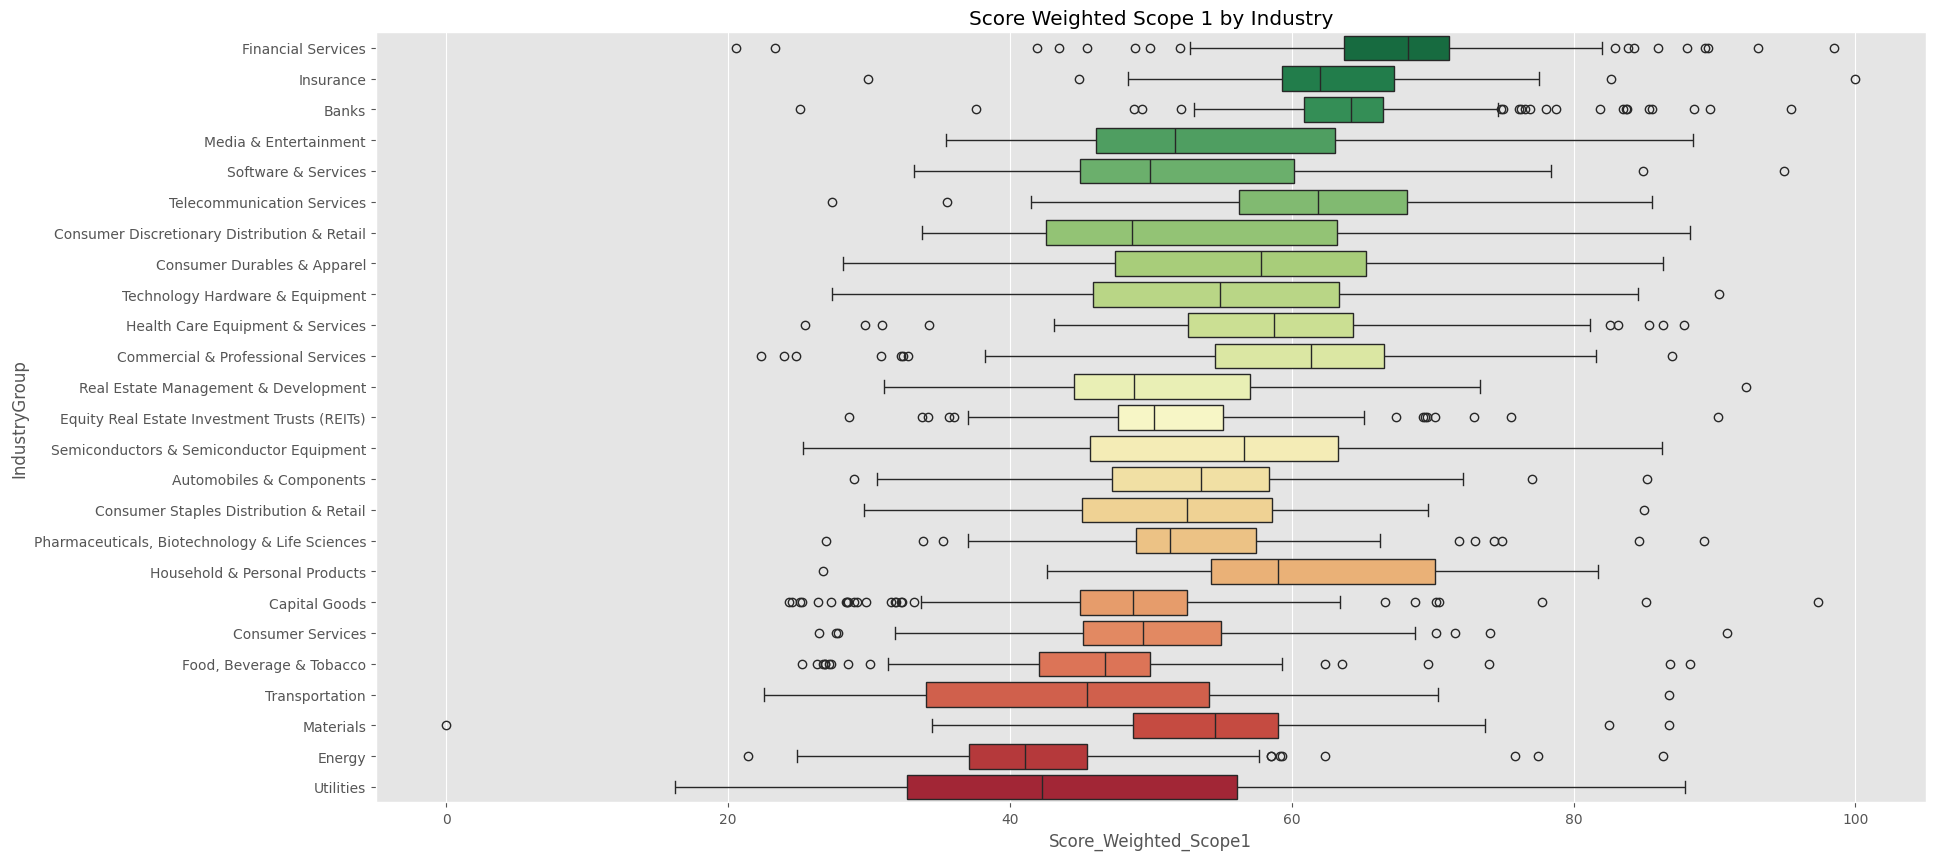

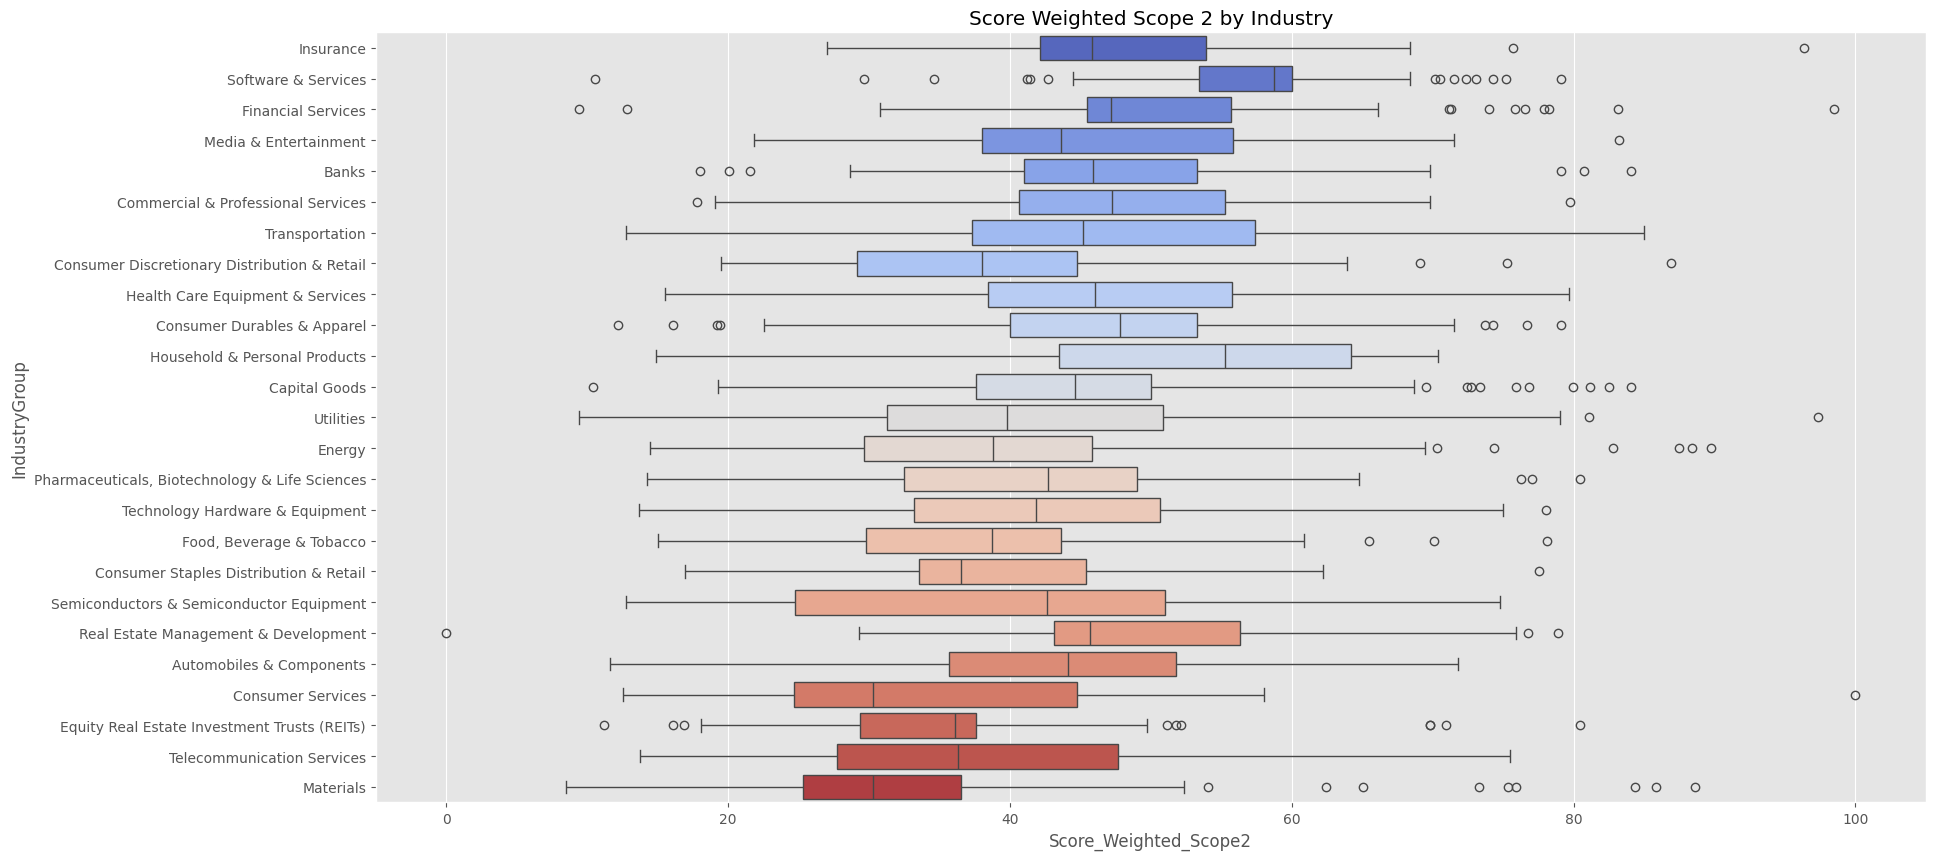

In [ ]:
plot_boxplot(
    df,
    column="Score_Weighted_Scope1",
    hue="IndustryGroup",
    order=order_scope1[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope1,
    title="Score Weighted Scope 1 by Industry",
)
plot_boxplot(
    df,
    column="Score_Weighted_Scope2",
    hue="IndustryGroup",
    order=order_scope2[
        ::-1
    ],  # Reverse order to have the highest impact ratios at the top
    palette=order_colors_scope2,
    title="Score Weighted Scope 2 by Industry",
)

![image](scores.png)

## References

- ESG Scores and Raw Data
https://www.spglobal.com/sustainable1/en/solutions/esg-scores-data

- S&P Global ESG Scores Methodology
https://portal.s1.spglobal.com/survey/documents/spglobal_esg_scores_methodology.pdf

- CSA Methodology
https://www.spglobal.com/sustainable1/en/csa/methodology


Some scores:

- https://finance.yahoo.com/quote/SAN.MC/sustainability/

- https://www.santanderassetmanagement.com/content/view/7728/file/SAM_%20SUSTAINABLE%20WEALTH%20ACADEMY_ESG%20RATINGS.pdf

- https://www.lseg.com/en/data-analytics/sustainable-finance/esg-scores?esg=Banco+Santander+SA

The S&P Global ESG Score cannot be compared across industries

The S&P Global ESG Score uses a double materiality approach whereby a sustainability issue is considered to be material if it presents a significant impact on society or the environment and a significant impact on a company's value drivers, competitive position, and long-term shareholder value creation.